# Reproduction du Phénomène de Double Descente sur MNIST avec TensorFlow

## Introduction

Dans ce projet, nous allons reproduire le phénomène de **double descente** observé en apprentissage automatique. Ce phénomène décrit comment la performance d'un modèle d'apprentissage automatique peut d'abord diminuer puis augmenter à nouveau en augmentant la complexité du modèle, ce qui va à l'encontre de l'intuition du compromis biais-variance traditionnel.

Nous utiliserons le jeu de données MNIST, composé d'images de chiffres manuscrits, et nous entraînerons des modèles de réseaux de neurones avec différentes architectures. Nous intégrerons également des modèles de **Random Fourier Features**, et nous permettrons le choix de différents optimisateurs et fonctions de perte.

## Partie 1 : Concepts en Apprentissage Automatique

### Sous-apprentissage et Surapprentissage

- **Sous-apprentissage (Underfitting)** : se produit lorsqu'un modèle est trop simple pour capturer la structure sous-jacente des données. Il en résulte une performance médiocre tant sur les données d'entraînement que sur les données de test.
- **Surapprentissage (Overfitting)** : se produit lorsqu'un modèle est trop complexe et s'adapte trop étroitement aux données d'entraînement, y compris le bruit. Il en résulte une performance élevée sur les données d'entraînement mais médiocre sur les données de test.

### Compromis Biais-Variance

- **Biais** : erreur due aux approximations dans l'algorithme d'apprentissage. Un biais élevé peut entraîner un sous-apprentissage.
- **Variance** : erreur due à la sensibilité du modèle aux petites fluctuations dans les données d'entraînement. Une variance élevée peut entraîner un surapprentissage.

Traditionnellement, en augmentant la complexité du modèle, on s'attend à réduire le biais mais à augmenter la variance, ce qui suggère un point optimal de complexité.

### Phénomène de Double Descente

Le phénomène de **double descente** remet en question le compromis biais-variance traditionnel. Il a été observé que la courbe d'erreur peut avoir deux minima en fonction de la complexité du modèle :

1. **Régime classique** : l'erreur diminue jusqu'à un minimum (lié au surapprentissage traditionnel).
2. **Régime moderne** : en augmentant encore la complexité, l'erreur diminue à nouveau après un pic, ce qui suggère qu'un modèle très complexe peut généraliser mieux qu'un modèle de complexité intermédiaire.

## Partie 2 : Fondements Mathématiques

Le double descente est associé à la capacité du modèle à interpoler les données d'entraînement. Lorsque le nombre de paramètres du modèle dépasse le nombre d'exemples d'entraînement, le modèle peut parfaitement ajuster les données, menant à une ré-optimisation de l'erreur de généralisation.

## Partie 3 : Choix d'Implémentation

### Jeu de Données

- **MNIST** : base de données de 70 000 images de chiffres manuscrits (60 000 pour l'entraînement et 10 000 pour le test). Chaque image est en niveaux de gris de 28x28 pixels.

### Modèles

- **Réseau de Neurones Entièrement Connecté** : avec un nombre variable de neurones cachés.
- **Random Fourier Features (RFF)** : méthode pour approcher les noyaux à l'aide de projections aléatoires, permettant un apprentissage rapide.

### Optimisateurs

- **SGD (Stochastic Gradient Descent)** : optimiseur basique utilisant la descente de gradient stochastique.
- **Adam** : optimiseur adaptatif combinant les avantages d'Adagrad et RMSProp.

### Fonctions de Perte

- **MSE (Mean Squared Error)** : erreur quadratique moyenne, souvent utilisée pour les problèmes de régression.
- **Cross-Entropy** : fonction de perte adaptée aux problèmes de classification multiclasse.

### Choix des Hyperparamètres

- **Nombre de Neurones Cachés** : nous allons varier ce nombre pour observer le phénomène de double descente.
- **Nombre d'Époques** : fixé à 6000 pour permettre une convergence appropriée.
- **Apprentissage** : possibilité d'ajuster le taux d'apprentissage et d'utiliser des callbacks pour la gestion du taux.

## Partie 4 : Préparation des Données

### Importation des Bibliothèques



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses
from keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time
import pandas as pd



### Chargement et Prétraitement des Données



In [2]:
# Chargement des données MNIST
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Réduction du jeu d'entraînement pour accentuer le phénomène de double descente
train_images = train_images[:4000]
train_labels = train_labels[:4000]

# Normalisation des images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Mise en forme des images pour le réseau entièrement connecté
train_images_flat = train_images.reshape((-1, 28 * 28))
test_images_flat = test_images.reshape((-1, 28 * 28))



## Partie 5 : Définition des Modèles

### Modèle de Réseau de Neurones Entièrement Connecté



In [3]:
def create_dense_model(n_hidden_units, activation='relu'):
    model = keras.Sequential([
        layers.Dense(n_hidden_units, activation=activation, input_shape=(784,)),
        layers.Dense(10, activation='linear')
    ])
    return model



### Modèle Random Fourier Features



In [4]:
def create_rff_model(n_components, loss_function='mean_squared_error', optimizer='sgd'):
    class RFFLayer(layers.Layer):
        def __init__(self, output_dim):
            super(RFFLayer, self).__init__()
            self.output_dim = output_dim

        def build(self, input_shape):
            self.W = self.add_weight(shape=(input_shape[1], self.output_dim),
                                     initializer='random_normal',
                                     trainable=False)
            self.b = self.add_weight(shape=(self.output_dim,),
                                     initializer='random_uniform',
                                     trainable=False)

        def call(self, inputs):
            projection = tf.matmul(inputs, self.W) + self.b
            return tf.math.cos(projection)

    model = keras.Sequential([
        RFFLayer(n_components),
        layers.Dense(10, activation='linear')
    ])
    
    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=['accuracy'])
    return model



## Partie 6 : Entraînement et Évaluation des Modèles

### Configuration des Hyperparamètres



In [5]:
# Définition des configurations
model_types = ['Dense', 'RFF']
optimizers_dict = {
    'SGD': {'class': optimizers.SGD, 'params': {'learning_rate': 0.01, 'momentum': 0.95}},
    'Adam': {'class': optimizers.Adam, 'params': {'learning_rate': 0.001}}
}
loss_functions_dict = {
    'MSE': losses.MeanSquaredError(),
    'CE': losses.SparseCategoricalCrossentropy(from_logits=True)
}

n_hidden_units_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 40, 50, 75, 100, 125, 150, 175, 200, 225, 250, 300, 400, 500]
n_components_list = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 48, 49, 50, 51, 52, 53, 60, 70, 75, 80, 90, 100, 125, 150, 175, 200, 250]

max_epochs = 20

# Initialisation des résultats
results = {
    'model': [],
    'optimizer': [],
    'loss_function': [],
    'n_hidden_units': [],
    'n_parameters': [],
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': [],
    'training_time': []
}

In [6]:

print("Processing calculations...")

for model_type in model_types:
    for optimizer_name, optimizer_info in optimizers_dict.items():
        optimizer_class = optimizer_info['class']
        optimizer_params = optimizer_info['params']
        for loss_name, loss_fn in loss_functions_dict.items():
            if model_type == 'Dense':
                for n_hidden_units in tqdm(n_hidden_units_list, desc=f"Modèles {model_type}-{optimizer_name}-{loss_name}"):
                    start_time = time.time()
                    
                    # Création de l'optimiseur
                    optimizer = optimizer_class(**optimizer_params)
                    
                    # Création du modèle Dense
                    model = tf.keras.Sequential([
                        layers.Dense(n_hidden_units, activation='relu', input_shape=(784,)),
                        layers.Dense(10, activation='linear')
                    ])
                    
                    # Compilation du modèle
                    model.compile(optimizer=optimizer,
                                  loss=loss_fn,
                                  metrics=['accuracy'])
                    
                    # Callback pour ajuster le taux d'apprentissage
                    def scheduler(epoch, lr):
                        if (epoch + 1) % 500 == 0 and n_hidden_units <= 250:
                            return lr * 0.9
                        else:
                            return lr
                    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
                    
                    # Entraînement du modèle
                    history = model.fit(
                        train_images_flat,
                        tf.one_hot(train_labels, 10) if loss_name == 'MSE' else train_labels,
                        epochs=max_epochs,
                        batch_size=128,
                        verbose=0,
                        callbacks=[lr_scheduler]
                    )
                    
                    # Évaluation du modèle
                    if loss_name == 'MSE':
                        train_loss, train_acc = model.evaluate(train_images_flat, tf.one_hot(train_labels, 10), verbose=0)
                        test_loss, test_acc = model.evaluate(test_images_flat, tf.one_hot(test_labels, 10), verbose=0)
                    else:
                        train_loss, train_acc = model.evaluate(train_images_flat, train_labels, verbose=0)
                        test_loss, test_acc = model.evaluate(test_images_flat, test_labels, verbose=0)
                    
                    # Enregistrement des résultats
                    n_params = model.count_params()
                    results['model'].append(model_type)
                    results['optimizer'].append(optimizer_name)
                    results['loss_function'].append(loss_name)
                    results['n_hidden_units'].append(n_hidden_units)
                    results['n_parameters'].append(n_params)
                    results['train_losses'].append(train_loss)
                    results['test_losses'].append(test_loss)
                    results['train_accuracies'].append(train_acc * 100)
                    results['test_accuracies'].append(test_acc * 100)
                    elapsed_time = time.time() - start_time
                    results['training_time'].append(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
                    
                    print(f"Terminé : {model_type}-{optimizer_name}-{loss_name} | Neurones Cachés: {n_hidden_units}, Paramètres: {n_params}, Acc. Entraînement: {train_acc*100:.2f}%, Acc. Test: {test_acc*100:.2f}%, Temps: {elapsed_time:.2f}s")
            elif model_type == 'RFF':
                for n_components in tqdm(n_components_list, desc=f"Modèles {model_type}-{optimizer_name}-{loss_name}"):
                    start_time = time.time()
                    
                    # Création de l'optimiseur
                    optimizer = optimizer_class(**optimizer_params)
                    
                    # Création du modèle RFF
                    model = tf.keras.Sequential([
                        layers.Dense(n_components, activation='relu', input_shape=(784,)),
                        layers.Dense(10, activation='linear')
                    ])
                    
                    # Compilation du modèle
                    model.compile(optimizer=optimizer,
                                  loss=loss_fn,
                                  metrics=['accuracy'])
                    
                    # Callback pour ajuster le taux d'apprentissage
                    def scheduler(epoch, lr):
                        if (epoch + 1) % 500 == 0 and n_components <= 200:
                            return lr * 0.9
                        else:
                            return lr
                    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
                    
                    # Entraînement du modèle
                    history = model.fit(
                        train_images_flat,
                        tf.one_hot(train_labels, 10) if loss_name == 'MSE' else train_labels,
                        epochs=max_epochs,
                        batch_size=128,
                        verbose=0,
                        callbacks=[lr_scheduler]
                    )
                    
                    # Évaluation du modèle
                    if loss_name == 'MSE':
                        train_loss, train_acc = model.evaluate(train_images_flat, tf.one_hot(train_labels, 10), verbose=0)
                        test_loss, test_acc = model.evaluate(test_images_flat, tf.one_hot(test_labels, 10), verbose=0)
                    else:
                        train_loss, train_acc = model.evaluate(train_images_flat, train_labels, verbose=0)
                        test_loss, test_acc = model.evaluate(test_images_flat, test_labels, verbose=0)
                    
                    # Enregistrement des résultats
                    n_params = model.count_params()
                    results['model'].append(model_type)
                    results['optimizer'].append(optimizer_name)
                    results['loss_function'].append(loss_name)
                    results['n_hidden_units'].append(n_components)
                    results['n_parameters'].append(n_params)
                    results['train_losses'].append(train_loss)
                    results['test_losses'].append(test_loss)
                    results['train_accuracies'].append(train_acc * 100)
                    results['test_accuracies'].append(test_acc * 100)
                    elapsed_time = time.time() - start_time
                    results['training_time'].append(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
                    
                    print(f"Terminé : {model_type}-{optimizer_name}-{loss_name} | Composantes RFF: {n_components}, Paramètres: {n_params}, Acc. Entraînement: {train_acc*100:.2f}%, Acc. Test: {test_acc*100:.2f}%, Temps: {elapsed_time:.2f}s")


Processing calculations...


Modèles Dense-SGD-MSE:   0%|          | 0/28 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Modèles Dense-SGD-MSE:   4%|▎         | 1/28 [00:00<00:25,  1.06it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 1, Paramètres: 805, Acc. Entraînement: 11.10%, Acc. Test: 11.35%, Temps: 0.94s


Modèles Dense-SGD-MSE:   7%|▋         | 2/28 [00:01<00:22,  1.15it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 2, Paramètres: 1600, Acc. Entraînement: 11.10%, Acc. Test: 11.35%, Temps: 0.83s


Modèles Dense-SGD-MSE:  11%|█         | 3/28 [00:02<00:21,  1.16it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 3, Paramètres: 2395, Acc. Entraînement: 20.33%, Acc. Test: 20.61%, Temps: 0.85s


Modèles Dense-SGD-MSE:  14%|█▍        | 4/28 [00:03<00:21,  1.14it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 4, Paramètres: 3190, Acc. Entraînement: 27.50%, Acc. Test: 27.19%, Temps: 0.91s


Modèles Dense-SGD-MSE:  18%|█▊        | 5/28 [00:04<00:21,  1.06it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 5, Paramètres: 3985, Acc. Entraînement: 28.65%, Acc. Test: 29.39%, Temps: 1.06s


Modèles Dense-SGD-MSE:  21%|██▏       | 6/28 [00:05<00:20,  1.08it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 6, Paramètres: 4780, Acc. Entraînement: 16.60%, Acc. Test: 15.66%, Temps: 0.90s


Modèles Dense-SGD-MSE:  25%|██▌       | 7/28 [00:06<00:18,  1.13it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 7, Paramètres: 5575, Acc. Entraînement: 40.95%, Acc. Test: 39.91%, Temps: 0.78s


Modèles Dense-SGD-MSE:  29%|██▊       | 8/28 [00:07<00:17,  1.17it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 8, Paramètres: 6370, Acc. Entraînement: 41.60%, Acc. Test: 40.08%, Temps: 0.79s


Modèles Dense-SGD-MSE:  32%|███▏      | 9/28 [00:07<00:16,  1.17it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 9, Paramètres: 7165, Acc. Entraînement: 30.02%, Acc. Test: 29.72%, Temps: 0.85s


Modèles Dense-SGD-MSE:  36%|███▌      | 10/28 [00:08<00:15,  1.20it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 10, Paramètres: 7960, Acc. Entraînement: 70.28%, Acc. Test: 68.01%, Temps: 0.79s


Modèles Dense-SGD-MSE:  39%|███▉      | 11/28 [00:09<00:14,  1.16it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 12, Paramètres: 9550, Acc. Entraînement: 59.15%, Acc. Test: 56.92%, Temps: 0.92s


Modèles Dense-SGD-MSE:  43%|████▎     | 12/28 [00:10<00:13,  1.19it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 15, Paramètres: 11935, Acc. Entraînement: 78.53%, Acc. Test: 74.04%, Temps: 0.81s


Modèles Dense-SGD-MSE:  46%|████▋     | 13/28 [00:11<00:12,  1.19it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 20, Paramètres: 15910, Acc. Entraînement: 77.63%, Acc. Test: 74.15%, Temps: 0.82s


Modèles Dense-SGD-MSE:  50%|█████     | 14/28 [00:12<00:11,  1.21it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 25, Paramètres: 19885, Acc. Entraînement: 81.12%, Acc. Test: 77.65%, Temps: 0.81s


Modèles Dense-SGD-MSE:  54%|█████▎    | 15/28 [00:12<00:10,  1.20it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 30, Paramètres: 23860, Acc. Entraînement: 85.47%, Acc. Test: 82.95%, Temps: 0.83s


Modèles Dense-SGD-MSE:  57%|█████▋    | 16/28 [00:13<00:10,  1.19it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 40, Paramètres: 31810, Acc. Entraînement: 89.05%, Acc. Test: 85.90%, Temps: 0.86s


Modèles Dense-SGD-MSE:  61%|██████    | 17/28 [00:14<00:09,  1.15it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 50, Paramètres: 39760, Acc. Entraînement: 89.05%, Acc. Test: 86.84%, Temps: 0.95s


Modèles Dense-SGD-MSE:  64%|██████▍   | 18/28 [00:15<00:08,  1.12it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 75, Paramètres: 59635, Acc. Entraînement: 91.37%, Acc. Test: 87.67%, Temps: 0.94s


Modèles Dense-SGD-MSE:  68%|██████▊   | 19/28 [00:16<00:08,  1.11it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 100, Paramètres: 79510, Acc. Entraînement: 91.33%, Acc. Test: 88.11%, Temps: 0.92s


Modèles Dense-SGD-MSE:  71%|███████▏  | 20/28 [00:17<00:07,  1.07it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 125, Paramètres: 99385, Acc. Entraînement: 92.75%, Acc. Test: 88.58%, Temps: 1.01s


Modèles Dense-SGD-MSE:  75%|███████▌  | 21/28 [00:18<00:06,  1.03it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 150, Paramètres: 119260, Acc. Entraînement: 93.00%, Acc. Test: 89.85%, Temps: 1.07s


Modèles Dense-SGD-MSE:  79%|███████▊  | 22/28 [00:19<00:05,  1.00it/s]

Terminé : Dense-SGD-MSE | Neurones Cachés: 175, Paramètres: 139135, Acc. Entraînement: 93.23%, Acc. Test: 89.86%, Temps: 1.06s


Modèles Dense-SGD-MSE:  82%|████████▏ | 23/28 [00:21<00:05,  1.10s/it]

Terminé : Dense-SGD-MSE | Neurones Cachés: 200, Paramètres: 159010, Acc. Entraînement: 94.23%, Acc. Test: 90.40%, Temps: 1.34s


Modèles Dense-SGD-MSE:  86%|████████▌ | 24/28 [00:22<00:04,  1.13s/it]

Terminé : Dense-SGD-MSE | Neurones Cachés: 225, Paramètres: 178885, Acc. Entraînement: 94.27%, Acc. Test: 90.12%, Temps: 1.20s


Modèles Dense-SGD-MSE:  89%|████████▉ | 25/28 [00:23<00:03,  1.29s/it]

Terminé : Dense-SGD-MSE | Neurones Cachés: 250, Paramètres: 198760, Acc. Entraînement: 94.27%, Acc. Test: 90.08%, Temps: 1.66s


Modèles Dense-SGD-MSE:  93%|█████████▎| 26/28 [00:25<00:02,  1.39s/it]

Terminé : Dense-SGD-MSE | Neurones Cachés: 300, Paramètres: 238510, Acc. Entraînement: 94.48%, Acc. Test: 90.54%, Temps: 1.61s


Modèles Dense-SGD-MSE:  96%|█████████▋| 27/28 [00:26<00:01,  1.42s/it]

Terminé : Dense-SGD-MSE | Neurones Cachés: 400, Paramètres: 318010, Acc. Entraînement: 95.25%, Acc. Test: 90.92%, Temps: 1.49s


Modèles Dense-SGD-MSE: 100%|██████████| 28/28 [00:28<00:00,  1.03s/it]


Terminé : Dense-SGD-MSE | Neurones Cachés: 500, Paramètres: 397510, Acc. Entraînement: 95.70%, Acc. Test: 91.11%, Temps: 1.77s


Modèles Dense-SGD-CE:   4%|▎         | 1/28 [00:00<00:20,  1.34it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 1, Paramètres: 805, Acc. Entraînement: 31.50%, Acc. Test: 29.40%, Temps: 0.75s


Modèles Dense-SGD-CE:   7%|▋         | 2/28 [00:01<00:19,  1.37it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 2, Paramètres: 1600, Acc. Entraînement: 59.15%, Acc. Test: 54.19%, Temps: 0.72s


Modèles Dense-SGD-CE:  11%|█         | 3/28 [00:02<00:21,  1.18it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 3, Paramètres: 2395, Acc. Entraînement: 76.17%, Acc. Test: 70.36%, Temps: 0.98s


Modèles Dense-SGD-CE:  14%|█▍        | 4/28 [00:03<00:21,  1.13it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 4, Paramètres: 3190, Acc. Entraînement: 85.10%, Acc. Test: 79.20%, Temps: 0.95s


Modèles Dense-SGD-CE:  18%|█▊        | 5/28 [00:04<00:19,  1.16it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 5, Paramètres: 3985, Acc. Entraînement: 84.28%, Acc. Test: 77.32%, Temps: 0.82s


Modèles Dense-SGD-CE:  21%|██▏       | 6/28 [00:05<00:18,  1.17it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 6, Paramètres: 4780, Acc. Entraînement: 91.85%, Acc. Test: 87.94%, Temps: 0.84s


Modèles Dense-SGD-CE:  25%|██▌       | 7/28 [00:05<00:17,  1.17it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 7, Paramètres: 5575, Acc. Entraînement: 88.98%, Acc. Test: 82.29%, Temps: 0.85s


Modèles Dense-SGD-CE:  29%|██▊       | 8/28 [00:06<00:16,  1.21it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 8, Paramètres: 6370, Acc. Entraînement: 95.03%, Acc. Test: 89.08%, Temps: 0.77s


Modèles Dense-SGD-CE:  32%|███▏      | 9/28 [00:07<00:15,  1.24it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 9, Paramètres: 7165, Acc. Entraînement: 94.00%, Acc. Test: 88.55%, Temps: 0.77s


Modèles Dense-SGD-CE:  36%|███▌      | 10/28 [00:08<00:15,  1.16it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 10, Paramètres: 7960, Acc. Entraînement: 94.63%, Acc. Test: 88.89%, Temps: 1.00s


Modèles Dense-SGD-CE:  39%|███▉      | 11/28 [00:09<00:14,  1.20it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 12, Paramètres: 9550, Acc. Entraînement: 94.00%, Acc. Test: 88.76%, Temps: 0.76s


Modèles Dense-SGD-CE:  43%|████▎     | 12/28 [00:10<00:14,  1.09it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 15, Paramètres: 11935, Acc. Entraînement: 95.82%, Acc. Test: 90.25%, Temps: 1.09s


Modèles Dense-SGD-CE:  46%|████▋     | 13/28 [00:11<00:14,  1.03it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 20, Paramètres: 15910, Acc. Entraînement: 95.82%, Acc. Test: 90.34%, Temps: 1.09s


Modèles Dense-SGD-CE:  50%|█████     | 14/28 [00:12<00:12,  1.09it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 25, Paramètres: 19885, Acc. Entraînement: 96.60%, Acc. Test: 90.97%, Temps: 0.81s


Modèles Dense-SGD-CE:  54%|█████▎    | 15/28 [00:13<00:12,  1.08it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 30, Paramètres: 23860, Acc. Entraînement: 96.60%, Acc. Test: 90.60%, Temps: 0.94s


Modèles Dense-SGD-CE:  57%|█████▋    | 16/28 [00:14<00:11,  1.07it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 40, Paramètres: 31810, Acc. Entraînement: 97.12%, Acc. Test: 91.29%, Temps: 0.94s


Modèles Dense-SGD-CE:  61%|██████    | 17/28 [00:15<00:10,  1.07it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 50, Paramètres: 39760, Acc. Entraînement: 97.35%, Acc. Test: 91.54%, Temps: 0.95s


Modèles Dense-SGD-CE:  64%|██████▍   | 18/28 [00:15<00:09,  1.08it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 75, Paramètres: 59635, Acc. Entraînement: 97.30%, Acc. Test: 91.26%, Temps: 0.91s


Modèles Dense-SGD-CE:  68%|██████▊   | 19/28 [00:16<00:08,  1.07it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 100, Paramètres: 79510, Acc. Entraînement: 97.72%, Acc. Test: 92.06%, Temps: 0.94s


Modèles Dense-SGD-CE:  71%|███████▏  | 20/28 [00:17<00:07,  1.03it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 125, Paramètres: 99385, Acc. Entraînement: 98.18%, Acc. Test: 92.18%, Temps: 1.07s


Modèles Dense-SGD-CE:  75%|███████▌  | 21/28 [00:19<00:06,  1.00it/s]

Terminé : Dense-SGD-CE | Neurones Cachés: 150, Paramètres: 119260, Acc. Entraînement: 98.03%, Acc. Test: 91.97%, Temps: 1.06s


Modèles Dense-SGD-CE:  79%|███████▊  | 22/28 [00:20<00:06,  1.02s/it]

Terminé : Dense-SGD-CE | Neurones Cachés: 175, Paramètres: 139135, Acc. Entraînement: 97.70%, Acc. Test: 91.64%, Temps: 1.08s


Modèles Dense-SGD-CE:  82%|████████▏ | 23/28 [00:21<00:05,  1.06s/it]

Terminé : Dense-SGD-CE | Neurones Cachés: 200, Paramètres: 159010, Acc. Entraînement: 98.20%, Acc. Test: 91.99%, Temps: 1.14s


Modèles Dense-SGD-CE:  86%|████████▌ | 24/28 [00:22<00:04,  1.11s/it]

Terminé : Dense-SGD-CE | Neurones Cachés: 225, Paramètres: 178885, Acc. Entraînement: 98.15%, Acc. Test: 91.92%, Temps: 1.22s


Modèles Dense-SGD-CE:  89%|████████▉ | 25/28 [00:23<00:03,  1.19s/it]

Terminé : Dense-SGD-CE | Neurones Cachés: 250, Paramètres: 198760, Acc. Entraînement: 98.43%, Acc. Test: 92.20%, Temps: 1.39s


Modèles Dense-SGD-CE:  93%|█████████▎| 26/28 [00:25<00:02,  1.23s/it]

Terminé : Dense-SGD-CE | Neurones Cachés: 300, Paramètres: 238510, Acc. Entraînement: 98.33%, Acc. Test: 92.23%, Temps: 1.33s


Modèles Dense-SGD-CE:  96%|█████████▋| 27/28 [00:26<00:01,  1.38s/it]

Terminé : Dense-SGD-CE | Neurones Cachés: 400, Paramètres: 318010, Acc. Entraînement: 98.25%, Acc. Test: 92.25%, Temps: 1.71s


Modèles Dense-SGD-CE: 100%|██████████| 28/28 [00:28<00:00,  1.02s/it]


Terminé : Dense-SGD-CE | Neurones Cachés: 500, Paramètres: 397510, Acc. Entraînement: 98.37%, Acc. Test: 92.23%, Temps: 1.71s


Modèles Dense-Adam-MSE:   4%|▎         | 1/28 [00:00<00:21,  1.24it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 1, Paramètres: 805, Acc. Entraînement: 20.50%, Acc. Test: 21.01%, Temps: 0.81s


Modèles Dense-Adam-MSE:   7%|▋         | 2/28 [00:01<00:21,  1.21it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 2, Paramètres: 1600, Acc. Entraînement: 21.73%, Acc. Test: 20.00%, Temps: 0.84s


Modèles Dense-Adam-MSE:  11%|█         | 3/28 [00:02<00:21,  1.18it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 3, Paramètres: 2395, Acc. Entraînement: 31.03%, Acc. Test: 30.07%, Temps: 0.88s


Modèles Dense-Adam-MSE:  14%|█▍        | 4/28 [00:03<00:20,  1.18it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 4, Paramètres: 3190, Acc. Entraînement: 31.75%, Acc. Test: 29.70%, Temps: 0.84s


Modèles Dense-Adam-MSE:  18%|█▊        | 5/28 [00:04<00:20,  1.14it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 5, Paramètres: 3985, Acc. Entraînement: 40.90%, Acc. Test: 39.05%, Temps: 0.93s


Modèles Dense-Adam-MSE:  21%|██▏       | 6/28 [00:05<00:19,  1.10it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 6, Paramètres: 4780, Acc. Entraînement: 69.05%, Acc. Test: 64.75%, Temps: 0.97s


Modèles Dense-Adam-MSE:  25%|██▌       | 7/28 [00:06<00:18,  1.13it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 7, Paramètres: 5575, Acc. Entraînement: 59.97%, Acc. Test: 58.87%, Temps: 0.84s


Modèles Dense-Adam-MSE:  29%|██▊       | 8/28 [00:07<00:17,  1.12it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 8, Paramètres: 6370, Acc. Entraînement: 50.75%, Acc. Test: 49.34%, Temps: 0.91s


Modèles Dense-Adam-MSE:  32%|███▏      | 9/28 [00:07<00:16,  1.14it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 9, Paramètres: 7165, Acc. Entraînement: 90.85%, Acc. Test: 86.24%, Temps: 0.84s


Modèles Dense-Adam-MSE:  36%|███▌      | 10/28 [00:08<00:15,  1.13it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 10, Paramètres: 7960, Acc. Entraînement: 79.05%, Acc. Test: 75.32%, Temps: 0.90s


Modèles Dense-Adam-MSE:  39%|███▉      | 11/28 [00:09<00:15,  1.12it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 12, Paramètres: 9550, Acc. Entraînement: 78.47%, Acc. Test: 74.36%, Temps: 0.91s


Modèles Dense-Adam-MSE:  43%|████▎     | 12/28 [00:10<00:14,  1.13it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 15, Paramètres: 11935, Acc. Entraînement: 92.08%, Acc. Test: 87.04%, Temps: 0.87s


Modèles Dense-Adam-MSE:  46%|████▋     | 13/28 [00:11<00:14,  1.03it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 20, Paramètres: 15910, Acc. Entraînement: 93.73%, Acc. Test: 88.67%, Temps: 1.16s


Modèles Dense-Adam-MSE:  50%|█████     | 14/28 [00:12<00:13,  1.05it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 25, Paramètres: 19885, Acc. Entraînement: 95.57%, Acc. Test: 90.44%, Temps: 0.90s


Modèles Dense-Adam-MSE:  54%|█████▎    | 15/28 [00:13<00:12,  1.04it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 30, Paramètres: 23860, Acc. Entraînement: 95.07%, Acc. Test: 89.88%, Temps: 0.98s


Modèles Dense-Adam-MSE:  57%|█████▋    | 16/28 [00:14<00:11,  1.04it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 40, Paramètres: 31810, Acc. Entraînement: 96.00%, Acc. Test: 91.02%, Temps: 0.96s


Modèles Dense-Adam-MSE:  61%|██████    | 17/28 [00:15<00:10,  1.03it/s]

Terminé : Dense-Adam-MSE | Neurones Cachés: 50, Paramètres: 39760, Acc. Entraînement: 96.68%, Acc. Test: 91.20%, Temps: 0.98s


Modèles Dense-Adam-MSE:  64%|██████▍   | 18/28 [00:16<00:10,  1.04s/it]

Terminé : Dense-Adam-MSE | Neurones Cachés: 75, Paramètres: 59635, Acc. Entraînement: 98.33%, Acc. Test: 92.86%, Temps: 1.22s


Modèles Dense-Adam-MSE:  68%|██████▊   | 19/28 [00:17<00:09,  1.08s/it]

Terminé : Dense-Adam-MSE | Neurones Cachés: 100, Paramètres: 79510, Acc. Entraînement: 98.77%, Acc. Test: 92.96%, Temps: 1.16s


Modèles Dense-Adam-MSE:  71%|███████▏  | 20/28 [00:19<00:08,  1.10s/it]

Terminé : Dense-Adam-MSE | Neurones Cachés: 125, Paramètres: 99385, Acc. Entraînement: 98.98%, Acc. Test: 93.23%, Temps: 1.16s


Modèles Dense-Adam-MSE:  75%|███████▌  | 21/28 [00:20<00:08,  1.18s/it]

Terminé : Dense-Adam-MSE | Neurones Cachés: 150, Paramètres: 119260, Acc. Entraînement: 99.62%, Acc. Test: 93.89%, Temps: 1.36s


Modèles Dense-Adam-MSE:  79%|███████▊  | 22/28 [00:21<00:07,  1.27s/it]

Terminé : Dense-Adam-MSE | Neurones Cachés: 175, Paramètres: 139135, Acc. Entraînement: 99.75%, Acc. Test: 93.59%, Temps: 1.49s


Modèles Dense-Adam-MSE:  82%|████████▏ | 23/28 [00:23<00:06,  1.32s/it]

Terminé : Dense-Adam-MSE | Neurones Cachés: 200, Paramètres: 159010, Acc. Entraînement: 99.67%, Acc. Test: 94.03%, Temps: 1.42s


Modèles Dense-Adam-MSE:  86%|████████▌ | 24/28 [00:24<00:05,  1.37s/it]

Terminé : Dense-Adam-MSE | Neurones Cachés: 225, Paramètres: 178885, Acc. Entraînement: 99.75%, Acc. Test: 93.93%, Temps: 1.49s


Modèles Dense-Adam-MSE:  89%|████████▉ | 25/28 [00:26<00:04,  1.42s/it]

Terminé : Dense-Adam-MSE | Neurones Cachés: 250, Paramètres: 198760, Acc. Entraînement: 99.92%, Acc. Test: 94.37%, Temps: 1.53s


Modèles Dense-Adam-MSE:  93%|█████████▎| 26/28 [00:27<00:02,  1.48s/it]

Terminé : Dense-Adam-MSE | Neurones Cachés: 300, Paramètres: 238510, Acc. Entraînement: 99.92%, Acc. Test: 94.51%, Temps: 1.63s


Modèles Dense-Adam-MSE:  96%|█████████▋| 27/28 [00:29<00:01,  1.59s/it]

Terminé : Dense-Adam-MSE | Neurones Cachés: 400, Paramètres: 318010, Acc. Entraînement: 100.00%, Acc. Test: 94.73%, Temps: 1.85s


Modèles Dense-Adam-MSE: 100%|██████████| 28/28 [00:31<00:00,  1.14s/it]


Terminé : Dense-Adam-MSE | Neurones Cachés: 500, Paramètres: 397510, Acc. Entraînement: 100.00%, Acc. Test: 94.68%, Temps: 2.10s


Modèles Dense-Adam-CE:   4%|▎         | 1/28 [00:01<00:30,  1.14s/it]

Terminé : Dense-Adam-CE | Neurones Cachés: 1, Paramètres: 805, Acc. Entraînement: 23.25%, Acc. Test: 22.46%, Temps: 1.14s


Modèles Dense-Adam-CE:   7%|▋         | 2/28 [00:01<00:24,  1.06it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 2, Paramètres: 1600, Acc. Entraînement: 38.57%, Acc. Test: 36.97%, Temps: 0.81s


Modèles Dense-Adam-CE:  11%|█         | 3/28 [00:02<00:23,  1.08it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 3, Paramètres: 2395, Acc. Entraînement: 66.15%, Acc. Test: 63.52%, Temps: 0.90s


Modèles Dense-Adam-CE:  14%|█▍        | 4/28 [00:03<00:21,  1.09it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 4, Paramètres: 3190, Acc. Entraînement: 77.47%, Acc. Test: 72.94%, Temps: 0.90s


Modèles Dense-Adam-CE:  18%|█▊        | 5/28 [00:04<00:21,  1.09it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 5, Paramètres: 3985, Acc. Entraînement: 85.30%, Acc. Test: 81.05%, Temps: 0.93s


Modèles Dense-Adam-CE:  21%|██▏       | 6/28 [00:05<00:20,  1.06it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 6, Paramètres: 4780, Acc. Entraînement: 87.23%, Acc. Test: 83.44%, Temps: 0.98s


Modèles Dense-Adam-CE:  25%|██▌       | 7/28 [00:06<00:19,  1.09it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 7, Paramètres: 5575, Acc. Entraînement: 91.07%, Acc. Test: 88.13%, Temps: 0.87s


Modèles Dense-Adam-CE:  29%|██▊       | 8/28 [00:07<00:18,  1.10it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 8, Paramètres: 6370, Acc. Entraînement: 89.38%, Acc. Test: 85.82%, Temps: 0.89s


Modèles Dense-Adam-CE:  32%|███▏      | 9/28 [00:08<00:16,  1.13it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 9, Paramètres: 7165, Acc. Entraînement: 92.05%, Acc. Test: 88.36%, Temps: 0.83s


Modèles Dense-Adam-CE:  36%|███▌      | 10/28 [00:09<00:16,  1.10it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 10, Paramètres: 7960, Acc. Entraînement: 93.48%, Acc. Test: 89.33%, Temps: 0.98s


Modèles Dense-Adam-CE:  39%|███▉      | 11/28 [00:10<00:15,  1.11it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 12, Paramètres: 9550, Acc. Entraînement: 92.98%, Acc. Test: 89.30%, Temps: 0.86s


Modèles Dense-Adam-CE:  43%|████▎     | 12/28 [00:10<00:14,  1.12it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 15, Paramètres: 11935, Acc. Entraînement: 94.75%, Acc. Test: 89.82%, Temps: 0.89s


Modèles Dense-Adam-CE:  46%|████▋     | 13/28 [00:11<00:13,  1.11it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 20, Paramètres: 15910, Acc. Entraînement: 95.40%, Acc. Test: 90.73%, Temps: 0.90s


Modèles Dense-Adam-CE:  50%|█████     | 14/28 [00:12<00:12,  1.09it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 25, Paramètres: 19885, Acc. Entraînement: 96.17%, Acc. Test: 91.14%, Temps: 0.95s


Modèles Dense-Adam-CE:  54%|█████▎    | 15/28 [00:13<00:12,  1.07it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 30, Paramètres: 23860, Acc. Entraînement: 96.70%, Acc. Test: 91.41%, Temps: 0.97s


Modèles Dense-Adam-CE:  57%|█████▋    | 16/28 [00:14<00:11,  1.06it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 40, Paramètres: 31810, Acc. Entraînement: 97.62%, Acc. Test: 91.68%, Temps: 0.98s


Modèles Dense-Adam-CE:  61%|██████    | 17/28 [00:15<00:10,  1.02it/s]

Terminé : Dense-Adam-CE | Neurones Cachés: 50, Paramètres: 39760, Acc. Entraînement: 98.03%, Acc. Test: 92.29%, Temps: 1.07s


Modèles Dense-Adam-CE:  64%|██████▍   | 18/28 [00:16<00:10,  1.01s/it]

Terminé : Dense-Adam-CE | Neurones Cachés: 75, Paramètres: 59635, Acc. Entraînement: 98.85%, Acc. Test: 92.08%, Temps: 1.07s


Modèles Dense-Adam-CE:  68%|██████▊   | 19/28 [00:17<00:09,  1.03s/it]

Terminé : Dense-Adam-CE | Neurones Cachés: 100, Paramètres: 79510, Acc. Entraînement: 99.30%, Acc. Test: 92.68%, Temps: 1.08s


Modèles Dense-Adam-CE:  71%|███████▏  | 20/28 [00:19<00:09,  1.19s/it]

Terminé : Dense-Adam-CE | Neurones Cachés: 125, Paramètres: 99385, Acc. Entraînement: 99.62%, Acc. Test: 93.02%, Temps: 1.57s


Modèles Dense-Adam-CE:  75%|███████▌  | 21/28 [00:20<00:08,  1.23s/it]

Terminé : Dense-Adam-CE | Neurones Cachés: 150, Paramètres: 119260, Acc. Entraînement: 99.55%, Acc. Test: 92.64%, Temps: 1.33s


Modèles Dense-Adam-CE:  79%|███████▊  | 22/28 [00:22<00:07,  1.29s/it]

Terminé : Dense-Adam-CE | Neurones Cachés: 175, Paramètres: 139135, Acc. Entraînement: 99.83%, Acc. Test: 92.71%, Temps: 1.42s


Modèles Dense-Adam-CE:  82%|████████▏ | 23/28 [00:23<00:06,  1.36s/it]

Terminé : Dense-Adam-CE | Neurones Cachés: 200, Paramètres: 159010, Acc. Entraînement: 99.83%, Acc. Test: 93.17%, Temps: 1.52s


Modèles Dense-Adam-CE:  86%|████████▌ | 24/28 [00:25<00:05,  1.39s/it]

Terminé : Dense-Adam-CE | Neurones Cachés: 225, Paramètres: 178885, Acc. Entraînement: 99.87%, Acc. Test: 93.05%, Temps: 1.47s


Modèles Dense-Adam-CE:  89%|████████▉ | 25/28 [00:26<00:04,  1.42s/it]

Terminé : Dense-Adam-CE | Neurones Cachés: 250, Paramètres: 198760, Acc. Entraînement: 99.92%, Acc. Test: 93.23%, Temps: 1.47s


Modèles Dense-Adam-CE:  93%|█████████▎| 26/28 [00:28<00:02,  1.48s/it]

Terminé : Dense-Adam-CE | Neurones Cachés: 300, Paramètres: 238510, Acc. Entraînement: 99.98%, Acc. Test: 93.48%, Temps: 1.63s


Modèles Dense-Adam-CE:  96%|█████████▋| 27/28 [00:30<00:01,  1.60s/it]

Terminé : Dense-Adam-CE | Neurones Cachés: 400, Paramètres: 318010, Acc. Entraînement: 100.00%, Acc. Test: 93.92%, Temps: 1.86s


Modèles Dense-Adam-CE: 100%|██████████| 28/28 [00:32<00:00,  1.15s/it]


Terminé : Dense-Adam-CE | Neurones Cachés: 500, Paramètres: 397510, Acc. Entraînement: 100.00%, Acc. Test: 93.89%, Temps: 2.04s


Modèles RFF-SGD-MSE:   4%|▎         | 1/28 [00:00<00:20,  1.34it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 1, Paramètres: 805, Acc. Entraînement: 10.75%, Acc. Test: 9.82%, Temps: 0.74s


Modèles RFF-SGD-MSE:   7%|▋         | 2/28 [00:01<00:19,  1.36it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 2, Paramètres: 1600, Acc. Entraînement: 19.70%, Acc. Test: 19.04%, Temps: 0.73s


Modèles RFF-SGD-MSE:  11%|█         | 3/28 [00:02<00:18,  1.33it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 5, Paramètres: 3985, Acc. Entraînement: 50.40%, Acc. Test: 48.38%, Temps: 0.78s


Modèles RFF-SGD-MSE:  14%|█▍        | 4/28 [00:03<00:18,  1.31it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 10, Paramètres: 7960, Acc. Entraînement: 38.12%, Acc. Test: 38.37%, Temps: 0.78s


Modèles RFF-SGD-MSE:  18%|█▊        | 5/28 [00:03<00:18,  1.25it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 15, Paramètres: 11935, Acc. Entraînement: 70.13%, Acc. Test: 67.44%, Temps: 0.86s


Modèles RFF-SGD-MSE:  21%|██▏       | 6/28 [00:04<00:18,  1.22it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 20, Paramètres: 15910, Acc. Entraînement: 74.58%, Acc. Test: 71.94%, Temps: 0.86s


Modèles RFF-SGD-MSE:  25%|██▌       | 7/28 [00:05<00:17,  1.20it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 25, Paramètres: 19885, Acc. Entraînement: 85.30%, Acc. Test: 82.08%, Temps: 0.85s


Modèles RFF-SGD-MSE:  29%|██▊       | 8/28 [00:06<00:16,  1.18it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 30, Paramètres: 23860, Acc. Entraînement: 85.55%, Acc. Test: 82.86%, Temps: 0.89s


Modèles RFF-SGD-MSE:  32%|███▏      | 9/28 [00:07<00:16,  1.16it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 35, Paramètres: 27835, Acc. Entraînement: 88.00%, Acc. Test: 84.65%, Temps: 0.89s


Modèles RFF-SGD-MSE:  36%|███▌      | 10/28 [00:08<00:15,  1.18it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 40, Paramètres: 31810, Acc. Entraînement: 88.05%, Acc. Test: 84.96%, Temps: 0.82s


Modèles RFF-SGD-MSE:  39%|███▉      | 11/28 [00:09<00:14,  1.17it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 45, Paramètres: 35785, Acc. Entraînement: 88.70%, Acc. Test: 85.82%, Temps: 0.87s


Modèles RFF-SGD-MSE:  43%|████▎     | 12/28 [00:09<00:13,  1.17it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 48, Paramètres: 38170, Acc. Entraînement: 89.35%, Acc. Test: 87.31%, Temps: 0.85s


Modèles RFF-SGD-MSE:  46%|████▋     | 13/28 [00:10<00:12,  1.16it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 49, Paramètres: 38965, Acc. Entraînement: 89.40%, Acc. Test: 86.58%, Temps: 0.88s


Modèles RFF-SGD-MSE:  50%|█████     | 14/28 [00:11<00:12,  1.13it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 50, Paramètres: 39760, Acc. Entraînement: 90.13%, Acc. Test: 87.02%, Temps: 0.95s


Modèles RFF-SGD-MSE:  54%|█████▎    | 15/28 [00:12<00:11,  1.12it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 51, Paramètres: 40555, Acc. Entraînement: 88.92%, Acc. Test: 85.71%, Temps: 0.91s


Modèles RFF-SGD-MSE:  57%|█████▋    | 16/28 [00:13<00:10,  1.10it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 52, Paramètres: 41350, Acc. Entraînement: 89.13%, Acc. Test: 85.08%, Temps: 0.93s


Modèles RFF-SGD-MSE:  61%|██████    | 17/28 [00:15<00:11,  1.05s/it]

Terminé : RFF-SGD-MSE | Composantes RFF: 53, Paramètres: 42145, Acc. Entraînement: 89.95%, Acc. Test: 86.59%, Temps: 1.39s


Modèles RFF-SGD-MSE:  64%|██████▍   | 18/28 [00:15<00:10,  1.02s/it]

Terminé : RFF-SGD-MSE | Composantes RFF: 60, Paramètres: 47710, Acc. Entraînement: 89.90%, Acc. Test: 87.41%, Temps: 0.95s


Modèles RFF-SGD-MSE:  68%|██████▊   | 19/28 [00:16<00:08,  1.01it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 70, Paramètres: 55660, Acc. Entraînement: 89.55%, Acc. Test: 86.92%, Temps: 0.92s


Modèles RFF-SGD-MSE:  71%|███████▏  | 20/28 [00:17<00:07,  1.01it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 75, Paramètres: 59635, Acc. Entraînement: 91.35%, Acc. Test: 87.29%, Temps: 0.98s


Modèles RFF-SGD-MSE:  75%|███████▌  | 21/28 [00:18<00:06,  1.02it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 80, Paramètres: 63610, Acc. Entraînement: 91.33%, Acc. Test: 87.99%, Temps: 0.95s


Modèles RFF-SGD-MSE:  79%|███████▊  | 22/28 [00:19<00:05,  1.02it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 90, Paramètres: 71560, Acc. Entraînement: 91.18%, Acc. Test: 88.29%, Temps: 1.00s


Modèles RFF-SGD-MSE:  82%|████████▏ | 23/28 [00:20<00:04,  1.02it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 100, Paramètres: 79510, Acc. Entraînement: 92.95%, Acc. Test: 89.13%, Temps: 0.97s


Modèles RFF-SGD-MSE:  86%|████████▌ | 24/28 [00:21<00:03,  1.00it/s]

Terminé : RFF-SGD-MSE | Composantes RFF: 125, Paramètres: 99385, Acc. Entraînement: 92.33%, Acc. Test: 89.27%, Temps: 1.04s


Modèles RFF-SGD-MSE:  89%|████████▉ | 25/28 [00:22<00:03,  1.03s/it]

Terminé : RFF-SGD-MSE | Composantes RFF: 150, Paramètres: 119260, Acc. Entraînement: 92.68%, Acc. Test: 89.31%, Temps: 1.10s


Modèles RFF-SGD-MSE:  93%|█████████▎| 26/28 [00:24<00:02,  1.07s/it]

Terminé : RFF-SGD-MSE | Composantes RFF: 175, Paramètres: 139135, Acc. Entraînement: 93.17%, Acc. Test: 89.74%, Temps: 1.15s


Modèles RFF-SGD-MSE:  96%|█████████▋| 27/28 [00:25<00:01,  1.11s/it]

Terminé : RFF-SGD-MSE | Composantes RFF: 200, Paramètres: 159010, Acc. Entraînement: 93.17%, Acc. Test: 89.38%, Temps: 1.21s


Modèles RFF-SGD-MSE: 100%|██████████| 28/28 [00:26<00:00,  1.05it/s]


Terminé : RFF-SGD-MSE | Composantes RFF: 250, Paramètres: 198760, Acc. Entraînement: 94.30%, Acc. Test: 90.47%, Temps: 1.28s


Modèles RFF-SGD-CE:   4%|▎         | 1/28 [00:00<00:18,  1.42it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 1, Paramètres: 805, Acc. Entraînement: 30.02%, Acc. Test: 29.23%, Temps: 0.70s


Modèles RFF-SGD-CE:   7%|▋         | 2/28 [00:01<00:20,  1.29it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 2, Paramètres: 1600, Acc. Entraînement: 62.27%, Acc. Test: 57.47%, Temps: 0.83s


Modèles RFF-SGD-CE:  11%|█         | 3/28 [00:02<00:20,  1.22it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 5, Paramètres: 3985, Acc. Entraînement: 88.80%, Acc. Test: 84.46%, Temps: 0.88s


Modèles RFF-SGD-CE:  14%|█▍        | 4/28 [00:03<00:21,  1.14it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 10, Paramètres: 7960, Acc. Entraînement: 93.83%, Acc. Test: 88.20%, Temps: 0.96s


Modèles RFF-SGD-CE:  18%|█▊        | 5/28 [00:04<00:19,  1.19it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 15, Paramètres: 11935, Acc. Entraînement: 95.95%, Acc. Test: 90.66%, Temps: 0.78s


Modèles RFF-SGD-CE:  21%|██▏       | 6/28 [00:04<00:18,  1.19it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 20, Paramètres: 15910, Acc. Entraînement: 96.28%, Acc. Test: 90.24%, Temps: 0.83s


Modèles RFF-SGD-CE:  25%|██▌       | 7/28 [00:05<00:17,  1.21it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 25, Paramètres: 19885, Acc. Entraînement: 96.93%, Acc. Test: 90.95%, Temps: 0.81s


Modèles RFF-SGD-CE:  29%|██▊       | 8/28 [00:06<00:16,  1.21it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 30, Paramètres: 23860, Acc. Entraînement: 96.68%, Acc. Test: 91.09%, Temps: 0.83s


Modèles RFF-SGD-CE:  32%|███▏      | 9/28 [00:07<00:15,  1.20it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 35, Paramètres: 27835, Acc. Entraînement: 96.47%, Acc. Test: 90.73%, Temps: 0.84s


Modèles RFF-SGD-CE:  36%|███▌      | 10/28 [00:08<00:15,  1.18it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 40, Paramètres: 31810, Acc. Entraînement: 97.45%, Acc. Test: 91.51%, Temps: 0.87s


Modèles RFF-SGD-CE:  39%|███▉      | 11/28 [00:09<00:14,  1.19it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 45, Paramètres: 35785, Acc. Entraînement: 96.57%, Acc. Test: 90.96%, Temps: 0.84s


Modèles RFF-SGD-CE:  43%|████▎     | 12/28 [00:10<00:13,  1.18it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 48, Paramètres: 38170, Acc. Entraînement: 97.25%, Acc. Test: 91.29%, Temps: 0.87s


Modèles RFF-SGD-CE:  46%|████▋     | 13/28 [00:10<00:12,  1.17it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 49, Paramètres: 38965, Acc. Entraînement: 97.28%, Acc. Test: 91.42%, Temps: 0.86s


Modèles RFF-SGD-CE:  50%|█████     | 14/28 [00:11<00:12,  1.16it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 50, Paramètres: 39760, Acc. Entraînement: 97.70%, Acc. Test: 91.44%, Temps: 0.88s


Modèles RFF-SGD-CE:  54%|█████▎    | 15/28 [00:12<00:11,  1.16it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 51, Paramètres: 40555, Acc. Entraînement: 96.97%, Acc. Test: 91.13%, Temps: 0.86s


Modèles RFF-SGD-CE:  57%|█████▋    | 16/28 [00:13<00:10,  1.16it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 52, Paramètres: 41350, Acc. Entraînement: 97.12%, Acc. Test: 91.60%, Temps: 0.87s


Modèles RFF-SGD-CE:  61%|██████    | 17/28 [00:14<00:10,  1.09it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 53, Paramètres: 42145, Acc. Entraînement: 97.07%, Acc. Test: 91.61%, Temps: 1.04s


Modèles RFF-SGD-CE:  64%|██████▍   | 18/28 [00:15<00:09,  1.07it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 60, Paramètres: 47710, Acc. Entraînement: 97.58%, Acc. Test: 91.72%, Temps: 0.98s


Modèles RFF-SGD-CE:  68%|██████▊   | 19/28 [00:16<00:08,  1.04it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 70, Paramètres: 55660, Acc. Entraînement: 97.10%, Acc. Test: 90.90%, Temps: 1.03s


Modèles RFF-SGD-CE:  71%|███████▏  | 20/28 [00:17<00:07,  1.05it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 75, Paramètres: 59635, Acc. Entraînement: 97.35%, Acc. Test: 91.27%, Temps: 0.93s


Modèles RFF-SGD-CE:  75%|███████▌  | 21/28 [00:18<00:06,  1.03it/s]

Terminé : RFF-SGD-CE | Composantes RFF: 80, Paramètres: 63610, Acc. Entraînement: 97.80%, Acc. Test: 91.76%, Temps: 1.02s


Modèles RFF-SGD-CE:  79%|███████▊  | 22/28 [00:20<00:07,  1.21s/it]

Terminé : RFF-SGD-CE | Composantes RFF: 90, Paramètres: 71560, Acc. Entraînement: 97.70%, Acc. Test: 91.68%, Temps: 1.76s


Modèles RFF-SGD-CE:  82%|████████▏ | 23/28 [00:21<00:05,  1.19s/it]

Terminé : RFF-SGD-CE | Composantes RFF: 100, Paramètres: 79510, Acc. Entraînement: 97.55%, Acc. Test: 91.68%, Temps: 1.14s


Modèles RFF-SGD-CE:  86%|████████▌ | 24/28 [00:22<00:04,  1.15s/it]

Terminé : RFF-SGD-CE | Composantes RFF: 125, Paramètres: 99385, Acc. Entraînement: 97.95%, Acc. Test: 92.02%, Temps: 1.04s


Modèles RFF-SGD-CE:  89%|████████▉ | 25/28 [00:23<00:03,  1.13s/it]

Terminé : RFF-SGD-CE | Composantes RFF: 150, Paramètres: 119260, Acc. Entraînement: 97.93%, Acc. Test: 92.07%, Temps: 1.11s


Modèles RFF-SGD-CE:  93%|█████████▎| 26/28 [00:24<00:02,  1.15s/it]

Terminé : RFF-SGD-CE | Composantes RFF: 175, Paramètres: 139135, Acc. Entraînement: 97.95%, Acc. Test: 92.09%, Temps: 1.20s


Modèles RFF-SGD-CE:  96%|█████████▋| 27/28 [00:26<00:01,  1.24s/it]

Terminé : RFF-SGD-CE | Composantes RFF: 200, Paramètres: 159010, Acc. Entraînement: 98.12%, Acc. Test: 92.24%, Temps: 1.45s


Modèles RFF-SGD-CE: 100%|██████████| 28/28 [00:27<00:00,  1.01it/s]


Terminé : RFF-SGD-CE | Composantes RFF: 250, Paramètres: 198760, Acc. Entraînement: 98.03%, Acc. Test: 91.64%, Temps: 1.40s


Modèles RFF-Adam-MSE:   4%|▎         | 1/28 [00:00<00:24,  1.08it/s]

Terminé : RFF-Adam-MSE | Composantes RFF: 1, Paramètres: 805, Acc. Entraînement: 21.42%, Acc. Test: 20.82%, Temps: 0.92s


Modèles RFF-Adam-MSE:   7%|▋         | 2/28 [00:01<00:25,  1.00it/s]

Terminé : RFF-Adam-MSE | Composantes RFF: 2, Paramètres: 1600, Acc. Entraînement: 21.50%, Acc. Test: 21.21%, Temps: 1.05s


Modèles RFF-Adam-MSE:  11%|█         | 3/28 [00:03<00:25,  1.02s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 5, Paramètres: 3985, Acc. Entraînement: 36.27%, Acc. Test: 33.81%, Temps: 1.04s


Modèles RFF-Adam-MSE:  14%|█▍        | 4/28 [00:03<00:23,  1.03it/s]

Terminé : RFF-Adam-MSE | Composantes RFF: 10, Paramètres: 7960, Acc. Entraînement: 80.65%, Acc. Test: 76.99%, Temps: 0.91s


Modèles RFF-Adam-MSE:  18%|█▊        | 5/28 [00:04<00:22,  1.04it/s]

Terminé : RFF-Adam-MSE | Composantes RFF: 15, Paramètres: 11935, Acc. Entraînement: 91.68%, Acc. Test: 86.81%, Temps: 0.93s


Modèles RFF-Adam-MSE:  21%|██▏       | 6/28 [00:05<00:21,  1.04it/s]

Terminé : RFF-Adam-MSE | Composantes RFF: 20, Paramètres: 15910, Acc. Entraînement: 92.90%, Acc. Test: 87.95%, Temps: 0.98s


Modèles RFF-Adam-MSE:  25%|██▌       | 7/28 [00:06<00:20,  1.03it/s]

Terminé : RFF-Adam-MSE | Composantes RFF: 25, Paramètres: 19885, Acc. Entraînement: 94.23%, Acc. Test: 89.92%, Temps: 0.97s


Modèles RFF-Adam-MSE:  29%|██▊       | 8/28 [00:07<00:19,  1.00it/s]

Terminé : RFF-Adam-MSE | Composantes RFF: 30, Paramètres: 23860, Acc. Entraînement: 94.63%, Acc. Test: 89.88%, Temps: 1.06s


Modèles RFF-Adam-MSE:  32%|███▏      | 9/28 [00:08<00:19,  1.00s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 35, Paramètres: 27835, Acc. Entraînement: 95.78%, Acc. Test: 90.40%, Temps: 1.02s


Modèles RFF-Adam-MSE:  36%|███▌      | 10/28 [00:09<00:17,  1.01it/s]

Terminé : RFF-Adam-MSE | Composantes RFF: 40, Paramètres: 31810, Acc. Entraînement: 96.88%, Acc. Test: 91.62%, Temps: 0.94s


Modèles RFF-Adam-MSE:  39%|███▉      | 11/28 [00:10<00:16,  1.01it/s]

Terminé : RFF-Adam-MSE | Composantes RFF: 45, Paramètres: 35785, Acc. Entraînement: 96.93%, Acc. Test: 91.60%, Temps: 1.01s


Modèles RFF-Adam-MSE:  43%|████▎     | 12/28 [00:11<00:15,  1.01it/s]

Terminé : RFF-Adam-MSE | Composantes RFF: 48, Paramètres: 38170, Acc. Entraînement: 96.82%, Acc. Test: 91.23%, Temps: 0.97s


Modèles RFF-Adam-MSE:  46%|████▋     | 13/28 [00:12<00:14,  1.00it/s]

Terminé : RFF-Adam-MSE | Composantes RFF: 49, Paramètres: 38965, Acc. Entraînement: 95.57%, Acc. Test: 90.70%, Temps: 1.02s


Modèles RFF-Adam-MSE:  50%|█████     | 14/28 [00:13<00:14,  1.00s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 50, Paramètres: 39760, Acc. Entraînement: 97.68%, Acc. Test: 91.74%, Temps: 1.02s


Modèles RFF-Adam-MSE:  54%|█████▎    | 15/28 [00:14<00:13,  1.02s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 51, Paramètres: 40555, Acc. Entraînement: 97.62%, Acc. Test: 92.34%, Temps: 1.06s


Modèles RFF-Adam-MSE:  57%|█████▋    | 16/28 [00:15<00:12,  1.01s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 52, Paramètres: 41350, Acc. Entraînement: 96.95%, Acc. Test: 91.38%, Temps: 0.98s


Modèles RFF-Adam-MSE:  61%|██████    | 17/28 [00:16<00:11,  1.01s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 53, Paramètres: 42145, Acc. Entraînement: 97.25%, Acc. Test: 91.66%, Temps: 1.01s


Modèles RFF-Adam-MSE:  64%|██████▍   | 18/28 [00:17<00:10,  1.00s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 60, Paramètres: 47710, Acc. Entraînement: 97.93%, Acc. Test: 91.99%, Temps: 0.99s


Modèles RFF-Adam-MSE:  68%|██████▊   | 19/28 [00:18<00:09,  1.04s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 70, Paramètres: 55660, Acc. Entraînement: 97.32%, Acc. Test: 91.19%, Temps: 1.11s


Modèles RFF-Adam-MSE:  71%|███████▏  | 20/28 [00:20<00:08,  1.05s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 75, Paramètres: 59635, Acc. Entraînement: 98.15%, Acc. Test: 92.38%, Temps: 1.08s


Modèles RFF-Adam-MSE:  75%|███████▌  | 21/28 [00:21<00:07,  1.06s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 80, Paramètres: 63610, Acc. Entraînement: 98.47%, Acc. Test: 92.32%, Temps: 1.09s


Modèles RFF-Adam-MSE:  79%|███████▊  | 22/28 [00:22<00:06,  1.09s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 90, Paramètres: 71560, Acc. Entraînement: 98.77%, Acc. Test: 92.76%, Temps: 1.16s


Modèles RFF-Adam-MSE:  82%|████████▏ | 23/28 [00:24<00:06,  1.31s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 100, Paramètres: 79510, Acc. Entraînement: 99.15%, Acc. Test: 93.21%, Temps: 1.82s


Modèles RFF-Adam-MSE:  86%|████████▌ | 24/28 [00:25<00:05,  1.32s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 125, Paramètres: 99385, Acc. Entraînement: 99.35%, Acc. Test: 93.66%, Temps: 1.36s


Modèles RFF-Adam-MSE:  89%|████████▉ | 25/28 [00:26<00:04,  1.35s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 150, Paramètres: 119260, Acc. Entraînement: 99.40%, Acc. Test: 93.60%, Temps: 1.42s


Modèles RFF-Adam-MSE:  93%|█████████▎| 26/28 [00:28<00:02,  1.39s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 175, Paramètres: 139135, Acc. Entraînement: 99.58%, Acc. Test: 93.92%, Temps: 1.47s


Modèles RFF-Adam-MSE:  96%|█████████▋| 27/28 [00:29<00:01,  1.43s/it]

Terminé : RFF-Adam-MSE | Composantes RFF: 200, Paramètres: 159010, Acc. Entraînement: 99.58%, Acc. Test: 94.04%, Temps: 1.51s


Modèles RFF-Adam-MSE: 100%|██████████| 28/28 [00:31<00:00,  1.13s/it]


Terminé : RFF-Adam-MSE | Composantes RFF: 250, Paramètres: 198760, Acc. Entraînement: 99.92%, Acc. Test: 94.25%, Temps: 1.67s


Modèles RFF-Adam-CE:   4%|▎         | 1/28 [00:00<00:23,  1.16it/s]

Terminé : RFF-Adam-CE | Composantes RFF: 1, Paramètres: 805, Acc. Entraînement: 20.95%, Acc. Test: 20.52%, Temps: 0.86s


Modèles RFF-Adam-CE:   7%|▋         | 2/28 [00:01<00:24,  1.07it/s]

Terminé : RFF-Adam-CE | Composantes RFF: 2, Paramètres: 1600, Acc. Entraînement: 44.03%, Acc. Test: 42.89%, Temps: 0.99s


Modèles RFF-Adam-CE:  11%|█         | 3/28 [00:02<00:23,  1.07it/s]

Terminé : RFF-Adam-CE | Composantes RFF: 5, Paramètres: 3985, Acc. Entraînement: 85.68%, Acc. Test: 80.92%, Temps: 0.93s


Modèles RFF-Adam-CE:  14%|█▍        | 4/28 [00:03<00:22,  1.09it/s]

Terminé : RFF-Adam-CE | Composantes RFF: 10, Paramètres: 7960, Acc. Entraînement: 93.08%, Acc. Test: 89.32%, Temps: 0.90s


Modèles RFF-Adam-CE:  18%|█▊        | 5/28 [00:04<00:21,  1.08it/s]

Terminé : RFF-Adam-CE | Composantes RFF: 15, Paramètres: 11935, Acc. Entraînement: 94.42%, Acc. Test: 90.69%, Temps: 0.93s


Modèles RFF-Adam-CE:  21%|██▏       | 6/28 [00:05<00:20,  1.06it/s]

Terminé : RFF-Adam-CE | Composantes RFF: 20, Paramètres: 15910, Acc. Entraînement: 95.07%, Acc. Test: 90.40%, Temps: 0.99s


Modèles RFF-Adam-CE:  25%|██▌       | 7/28 [00:06<00:19,  1.06it/s]

Terminé : RFF-Adam-CE | Composantes RFF: 25, Paramètres: 19885, Acc. Entraînement: 96.22%, Acc. Test: 91.24%, Temps: 0.93s


Modèles RFF-Adam-CE:  29%|██▊       | 8/28 [00:07<00:18,  1.05it/s]

Terminé : RFF-Adam-CE | Composantes RFF: 30, Paramètres: 23860, Acc. Entraînement: 97.00%, Acc. Test: 91.48%, Temps: 0.96s


Modèles RFF-Adam-CE:  32%|███▏      | 9/28 [00:08<00:18,  1.05it/s]

Terminé : RFF-Adam-CE | Composantes RFF: 35, Paramètres: 27835, Acc. Entraînement: 97.05%, Acc. Test: 91.01%, Temps: 0.96s


Modèles RFF-Adam-CE:  36%|███▌      | 10/28 [00:09<00:17,  1.05it/s]

Terminé : RFF-Adam-CE | Composantes RFF: 40, Paramètres: 31810, Acc. Entraînement: 97.62%, Acc. Test: 91.58%, Temps: 0.97s


Modèles RFF-Adam-CE:  39%|███▉      | 11/28 [00:10<00:16,  1.01it/s]

Terminé : RFF-Adam-CE | Composantes RFF: 45, Paramètres: 35785, Acc. Entraînement: 97.93%, Acc. Test: 91.73%, Temps: 1.06s


Modèles RFF-Adam-CE:  43%|████▎     | 12/28 [00:11<00:16,  1.01s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 48, Paramètres: 38170, Acc. Entraînement: 97.70%, Acc. Test: 91.51%, Temps: 1.06s


Modèles RFF-Adam-CE:  46%|████▋     | 13/28 [00:12<00:15,  1.00s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 49, Paramètres: 38965, Acc. Entraînement: 97.20%, Acc. Test: 91.31%, Temps: 0.98s


Modèles RFF-Adam-CE:  50%|█████     | 14/28 [00:13<00:14,  1.01s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 50, Paramètres: 39760, Acc. Entraînement: 97.43%, Acc. Test: 91.13%, Temps: 1.04s


Modèles RFF-Adam-CE:  54%|█████▎    | 15/28 [00:14<00:13,  1.02s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 51, Paramètres: 40555, Acc. Entraînement: 98.10%, Acc. Test: 91.83%, Temps: 1.05s


Modèles RFF-Adam-CE:  57%|█████▋    | 16/28 [00:15<00:12,  1.02s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 52, Paramètres: 41350, Acc. Entraînement: 98.37%, Acc. Test: 92.03%, Temps: 1.01s


Modèles RFF-Adam-CE:  61%|██████    | 17/28 [00:16<00:11,  1.03s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 53, Paramètres: 42145, Acc. Entraînement: 98.35%, Acc. Test: 91.80%, Temps: 1.04s


Modèles RFF-Adam-CE:  64%|██████▍   | 18/28 [00:17<00:10,  1.04s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 60, Paramètres: 47710, Acc. Entraînement: 98.52%, Acc. Test: 91.96%, Temps: 1.05s


Modèles RFF-Adam-CE:  68%|██████▊   | 19/28 [00:18<00:09,  1.05s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 70, Paramètres: 55660, Acc. Entraînement: 98.83%, Acc. Test: 92.06%, Temps: 1.09s


Modèles RFF-Adam-CE:  71%|███████▏  | 20/28 [00:19<00:08,  1.04s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 75, Paramètres: 59635, Acc. Entraînement: 98.85%, Acc. Test: 91.79%, Temps: 1.02s


Modèles RFF-Adam-CE:  75%|███████▌  | 21/28 [00:20<00:07,  1.07s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 80, Paramètres: 63610, Acc. Entraînement: 98.70%, Acc. Test: 92.03%, Temps: 1.14s


Modèles RFF-Adam-CE:  79%|███████▊  | 22/28 [00:22<00:07,  1.19s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 90, Paramètres: 71560, Acc. Entraînement: 99.10%, Acc. Test: 92.59%, Temps: 1.47s


Modèles RFF-Adam-CE:  82%|████████▏ | 23/28 [00:23<00:06,  1.26s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 100, Paramètres: 79510, Acc. Entraînement: 99.08%, Acc. Test: 92.46%, Temps: 1.41s


Modèles RFF-Adam-CE:  86%|████████▌ | 24/28 [00:25<00:05,  1.42s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 125, Paramètres: 99385, Acc. Entraînement: 99.60%, Acc. Test: 92.60%, Temps: 1.80s


Modèles RFF-Adam-CE:  89%|████████▉ | 25/28 [00:27<00:04,  1.41s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 150, Paramètres: 119260, Acc. Entraînement: 99.70%, Acc. Test: 92.57%, Temps: 1.39s


Modèles RFF-Adam-CE:  93%|█████████▎| 26/28 [00:28<00:02,  1.41s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 175, Paramètres: 139135, Acc. Entraînement: 99.77%, Acc. Test: 93.02%, Temps: 1.42s


Modèles RFF-Adam-CE:  96%|█████████▋| 27/28 [00:30<00:01,  1.67s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 200, Paramètres: 159010, Acc. Entraînement: 99.87%, Acc. Test: 93.05%, Temps: 2.27s


Modèles RFF-Adam-CE: 100%|██████████| 28/28 [00:32<00:00,  1.16s/it]

Terminé : RFF-Adam-CE | Composantes RFF: 250, Paramètres: 198760, Acc. Entraînement: 99.92%, Acc. Test: 93.39%, Temps: 1.73s


In [7]:
# Conversion des résultats en DataFrame
df_results = pd.DataFrame(results)


In [8]:

# Fonction de visualisation
def plot_double_descent(df, model_type, optimizer, loss_function):
    subset = df[(df['model'] == model_type) &
               (df['optimizer'] == optimizer) &
               (df['loss_function'] == loss_function)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(subset['n_parameters'], subset['train_losses'], marker='o', label='Entraînement')
    plt.plot(subset['n_parameters'], subset['test_losses'], marker='s', label='Test')
    plt.xlabel('Nombre de paramètres')
    plt.ylabel('Perte')
    plt.title(f'Double Descente des Pertes pour {model_type} avec {optimizer} et {loss_function}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(subset['n_parameters'], subset['train_accuracies'], marker='o', label='Entraînement')
    plt.plot(subset['n_parameters'], subset['test_accuracies'], marker='s', label='Test')
    plt.xlabel('Nombre de paramètres')
    plt.ylabel('Exactitude (%)')
    plt.title(f'Double Descente des Exactitudes pour {model_type} avec {optimizer} et {loss_function}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


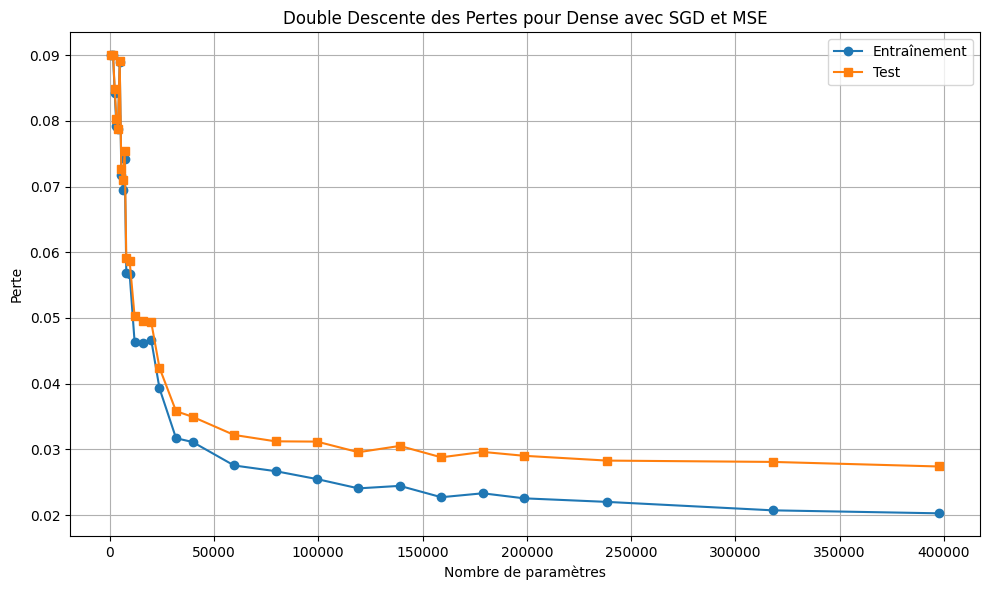

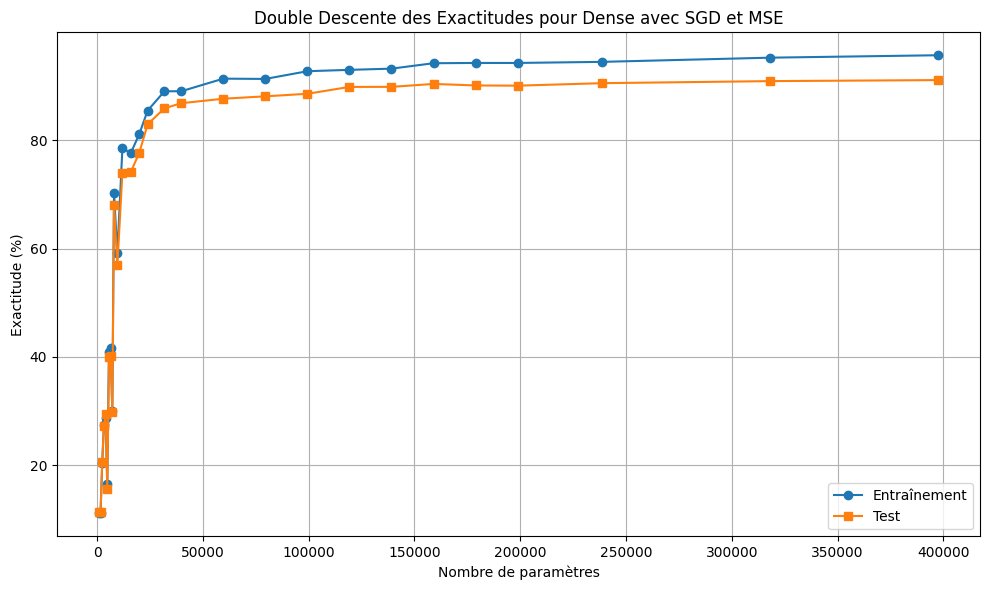

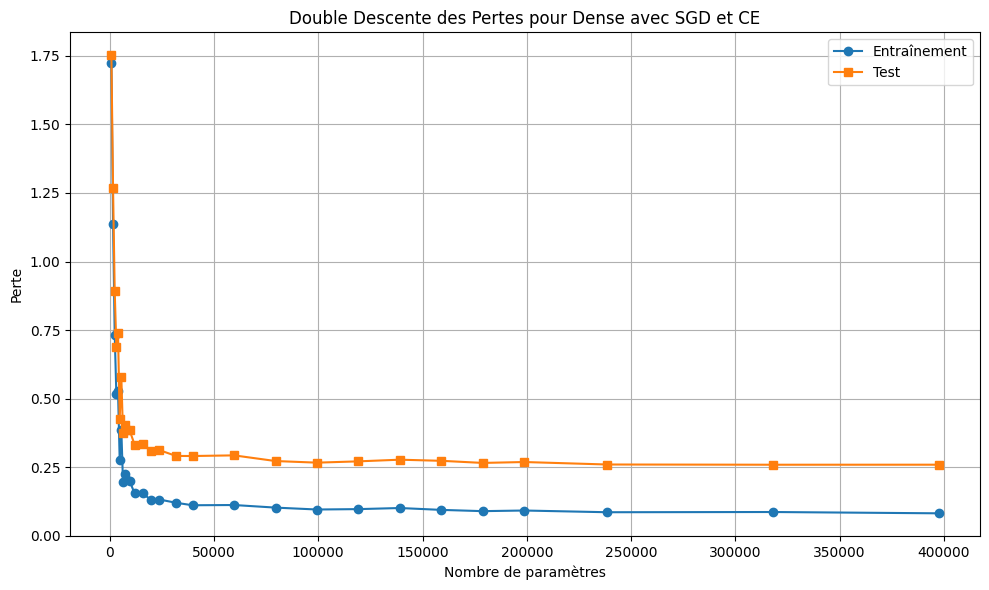

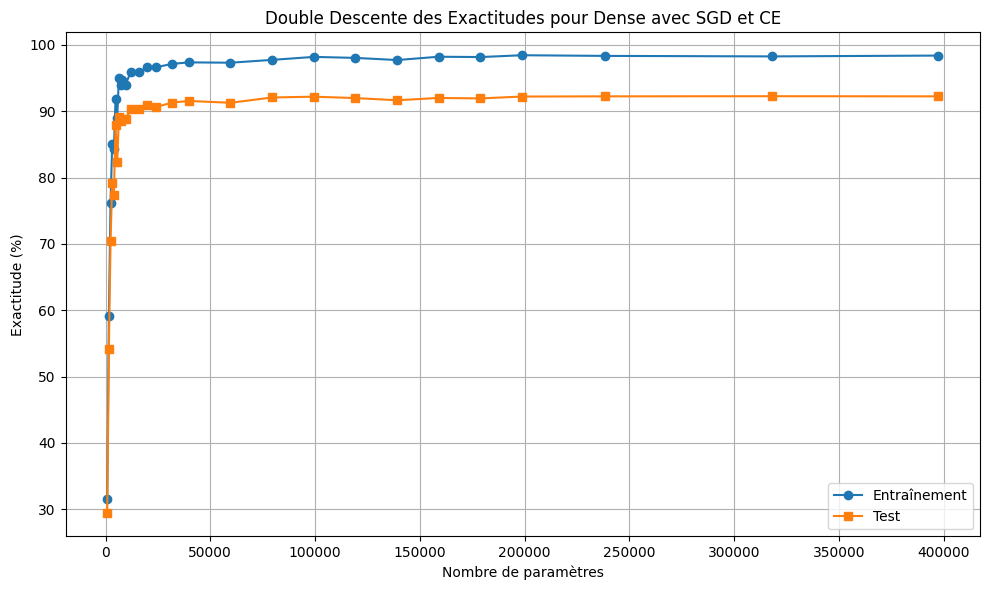

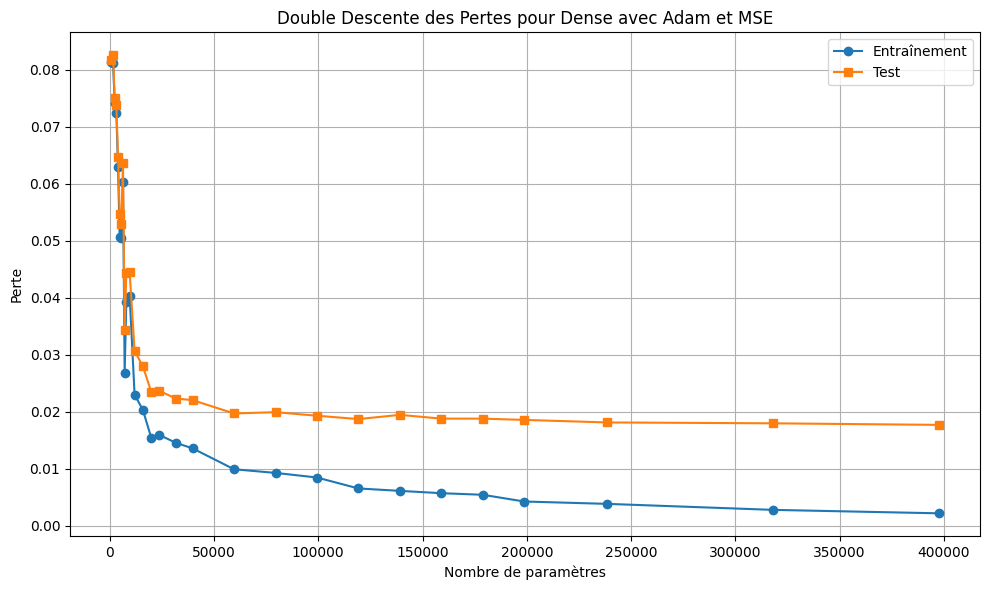

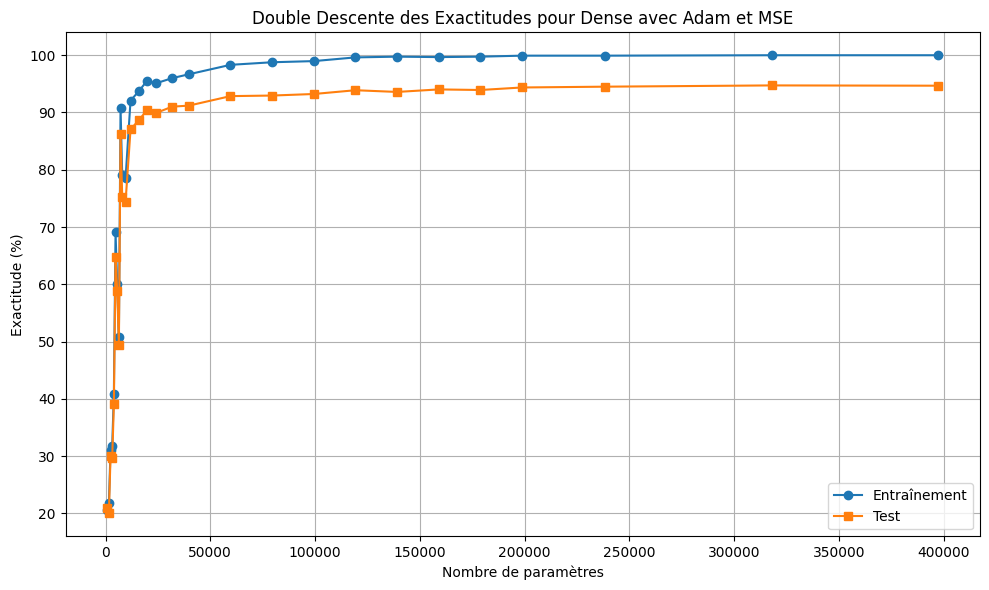

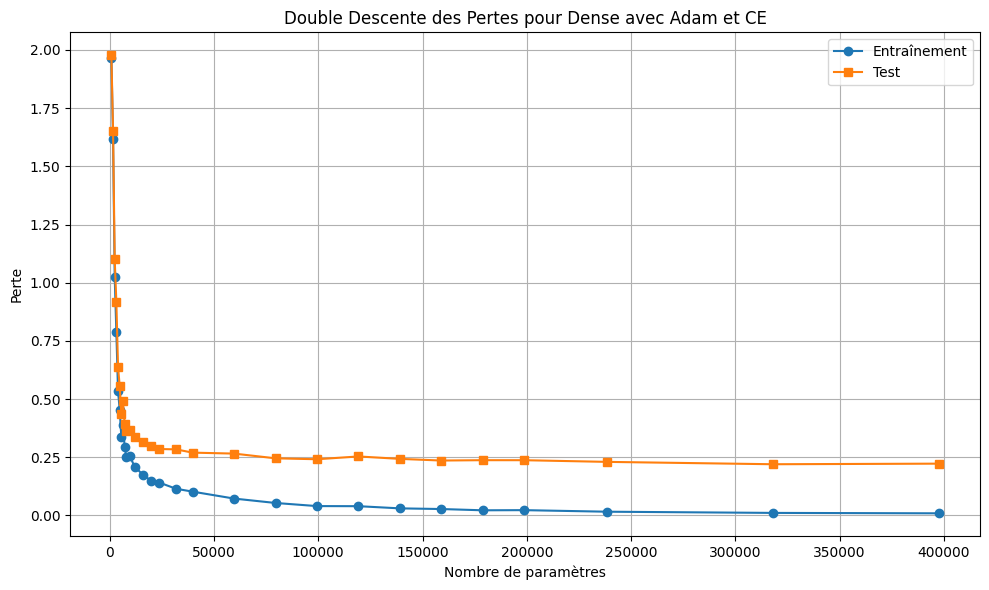

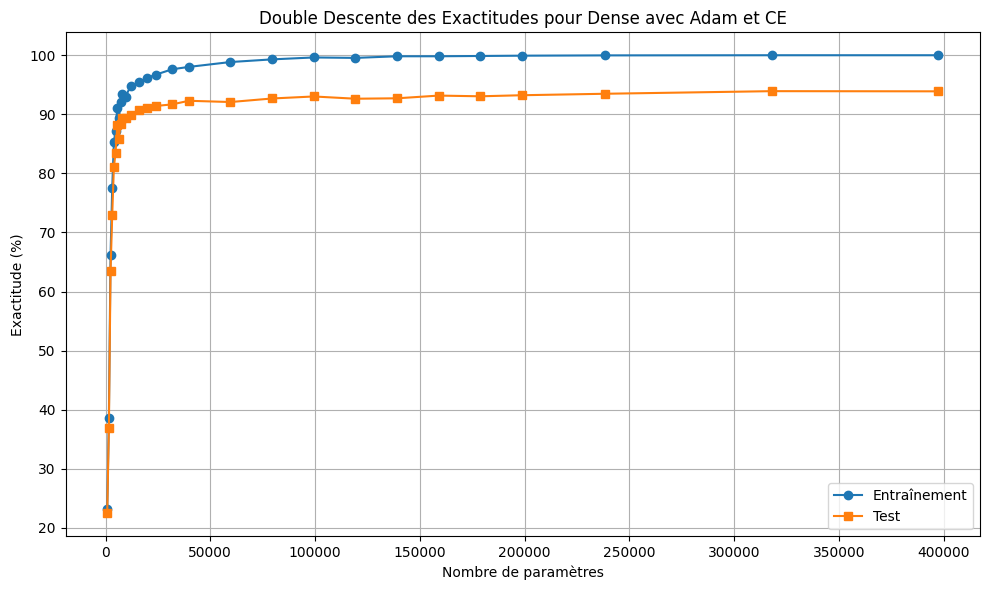

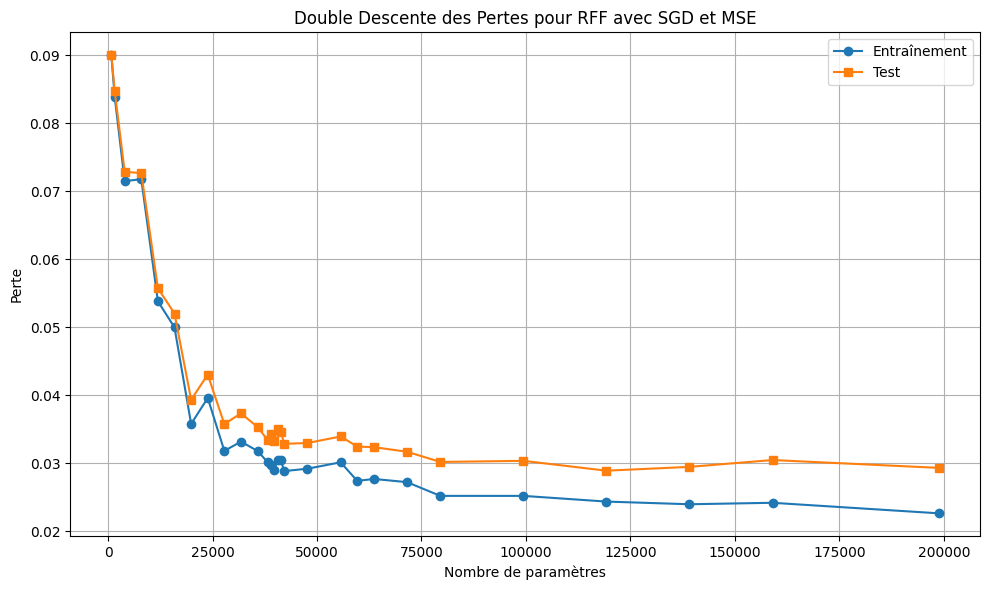

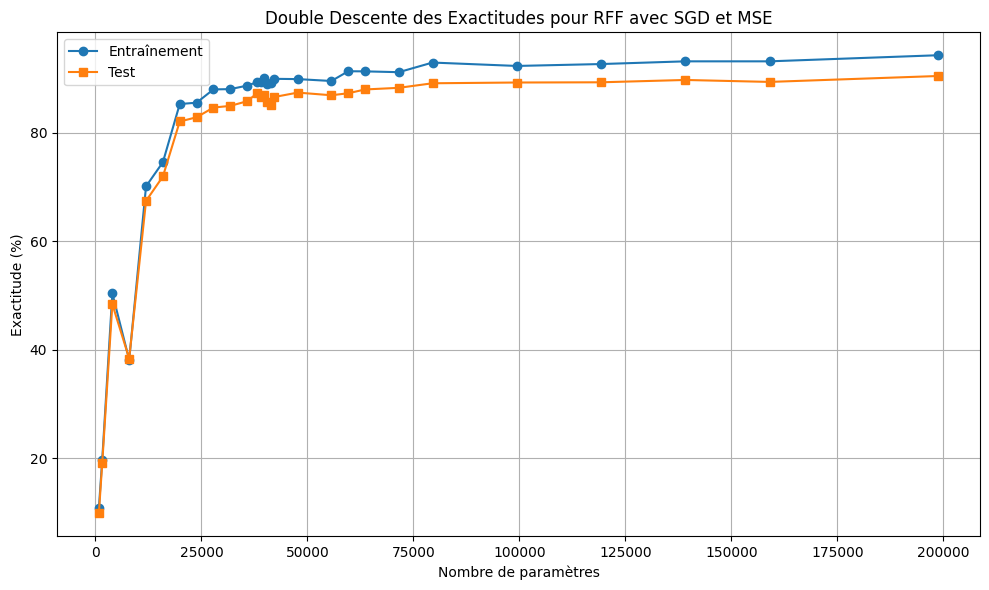

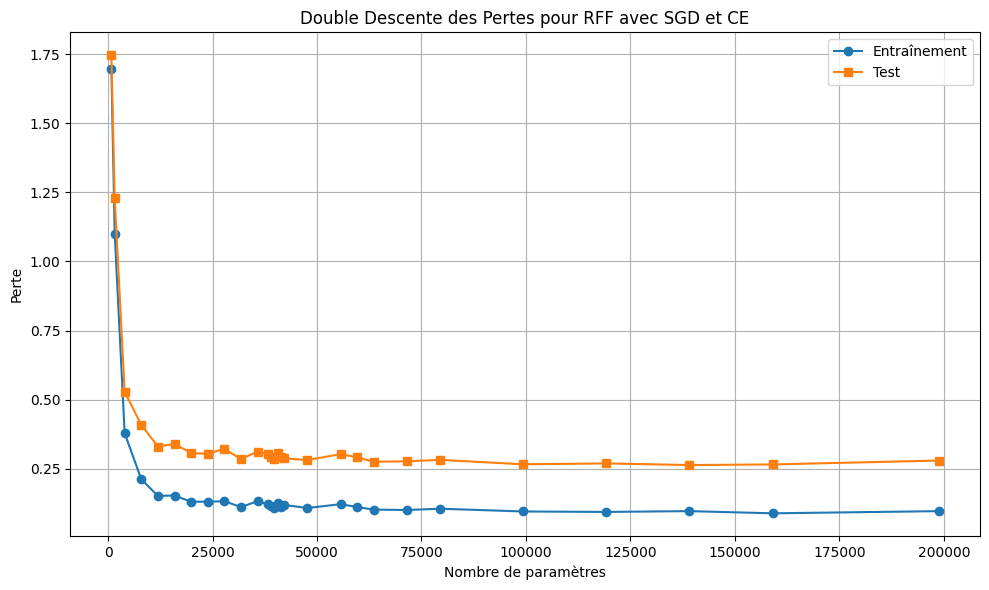

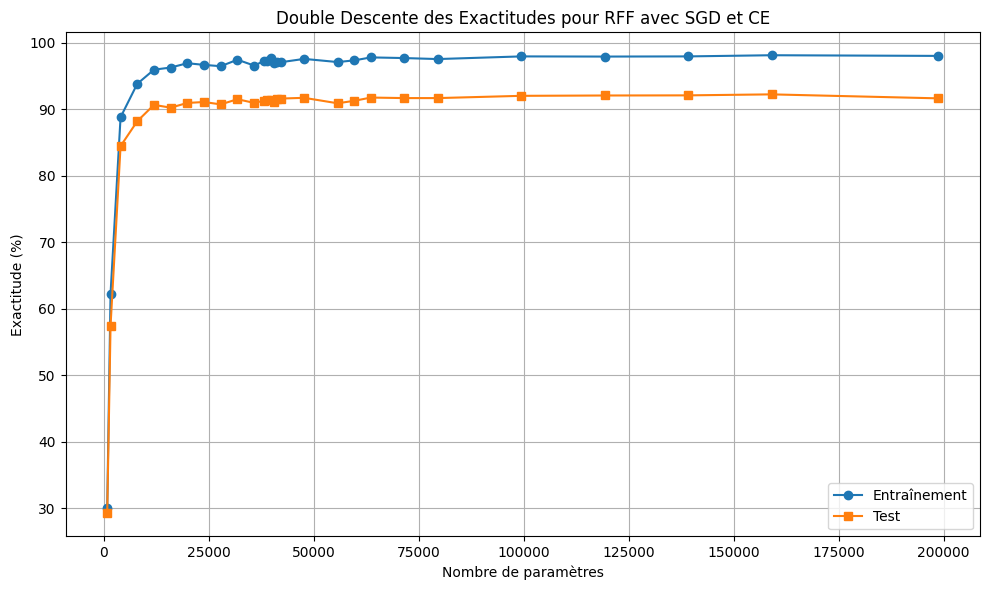

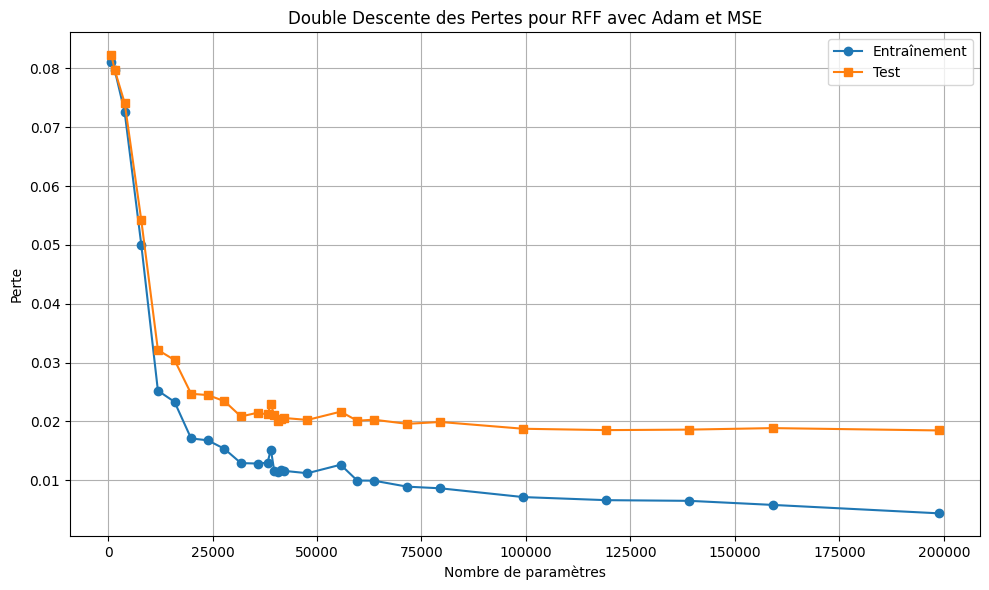

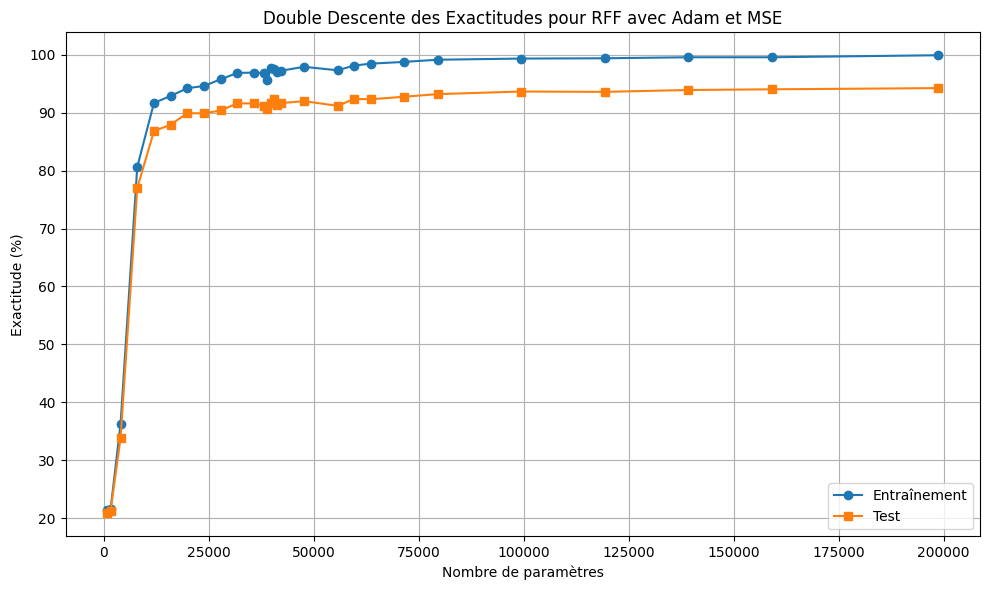

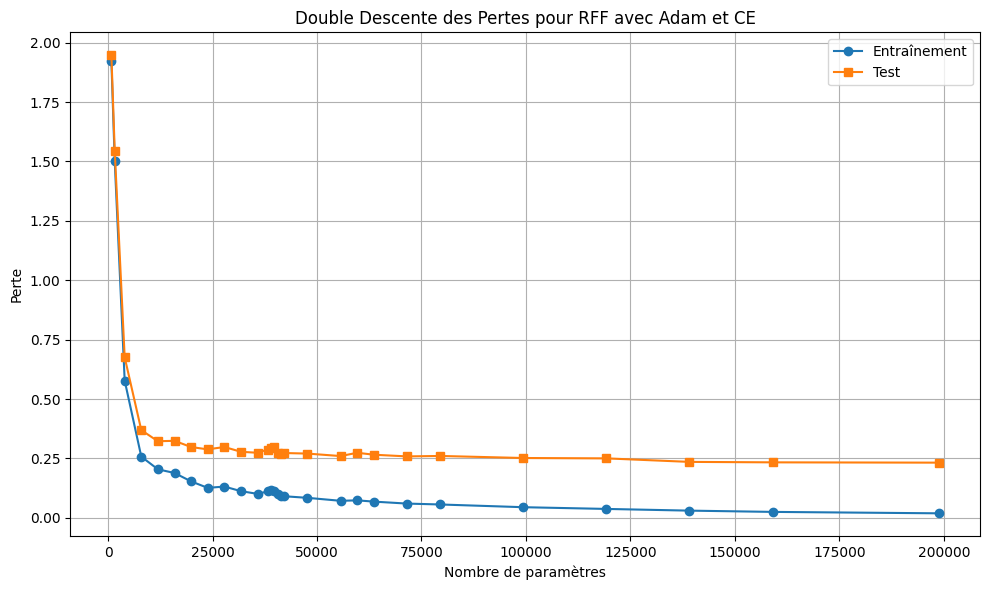

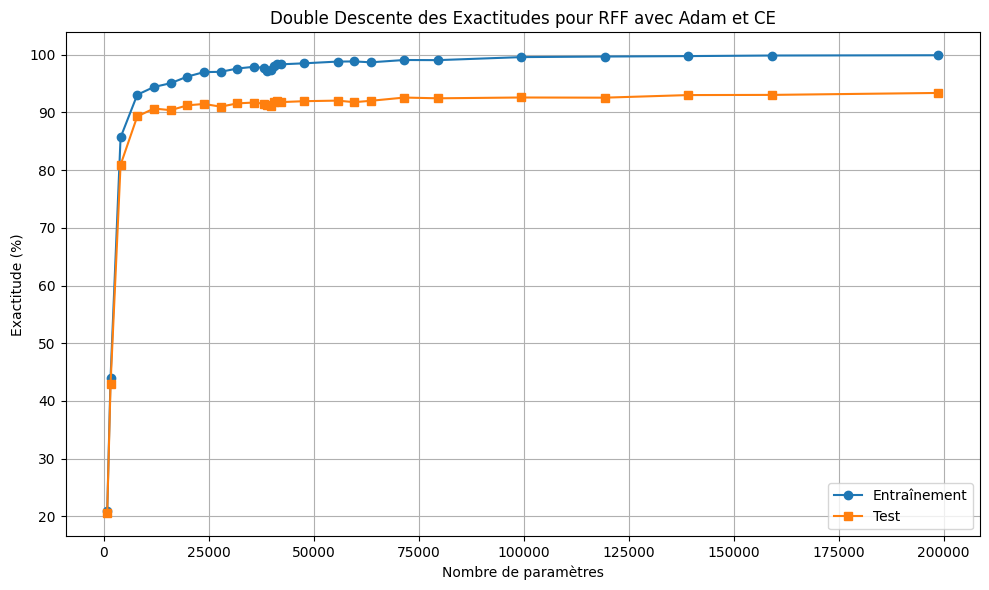

In [9]:

# Visualisation pour chaque combinaison
for model_type in model_types:
    for optimizer_name in optimizers_dict.keys():
        for loss_name in loss_functions_dict.keys():
            plot_double_descent(df_results, model_type, optimizer_name, loss_name)



---

# Partie 8 : Analyse des Résultats

En observant les courbes, on peut noter que :

- **Régime de Sous-Apprentissage :** Pour un petit nombre de paramètres, le modèle n'est pas assez complexe pour capturer la structure des données, d'où une performance faible.
- **Premier Minimum :** En augmentant la complexité, la performance s'améliore jusqu'à un certain point.
- **Pic d'Erreur :** En continuant d'augmenter le nombre de paramètres, l'erreur augmente à nouveau, suggérant un surapprentissage traditionnel.
- **Deuxième Descente :** En augmentant encore la complexité, l'erreur diminue à nouveau, ce qui correspond au phénomène de double descente.

Ces observations sont cohérentes avec le phénomène de double descente, où une complexité excessive du modèle permet de mieux généraliser malgré une augmentation initiale de l'erreur.

---

# Partie 9 : Conclusion

Nous avons réussi à reproduire le phénomène de double descente en entraînant des modèles avec différentes complexités sur le jeu de données MNIST. Cette expérience illustre l'importance de considérer des modèles de grande capacité dans certains contextes, car ils peuvent offrir une meilleure généralisation malgré une complexité accrue.

---

# Annexes

## Possibilités d'Améliorations et Expérimentations Supplémentaires

- **Essayer Différents Optimisateurs :** Remplacer SGD par d'autres optimiseurs comme RMSProp pour observer l'impact sur le phénomène.
- **Changer la Fonction de Perte :** Utiliser d'autres fonctions de perte telles que la **Cross-Entropy** ou **Hinge Loss**.
- **Intégrer des Modèles RFF Plus Complexes :** Expérimenter avec des architectures RFF plus sophistiquées ou augmenter le nombre de composantes.
- **Augmenter la Taille du Jeu d'Entraînement :** Étudier comment le phénomène évolue avec un plus grand nombre d'exemples d'entraînement.
- **Ajouter de la Régularisation :** Utiliser des techniques comme le **Dropout** ou la **Pénalisation L2** pour réduire le surapprentissage.
- **Tester sur un Autre Jeu de Données :** Par exemple, **CIFAR-10** pour évaluer la généralité du phénomène de double descente.
- **Varier le Nombre de Composantes RFF :** Pour mieux comprendre comment la dimensionnalité des RFF affecte la performance.
- **Étudier l'Impact de la Taille des Époques :** Modifier le nombre d'époques d'entraînement pour observer comment cela influence le phénomène.

Ces avenues d'amélioration permettent d'approfondir la compréhension du phénomène de double descente et de ses implications en apprentissage automatique.

---

*Fin du notebook.*

# TEST

Processing calculations...


Modèles RFF-Adam-CE: 100%|██████████| 64/64 [00:54<00:00,  1.18it/s]


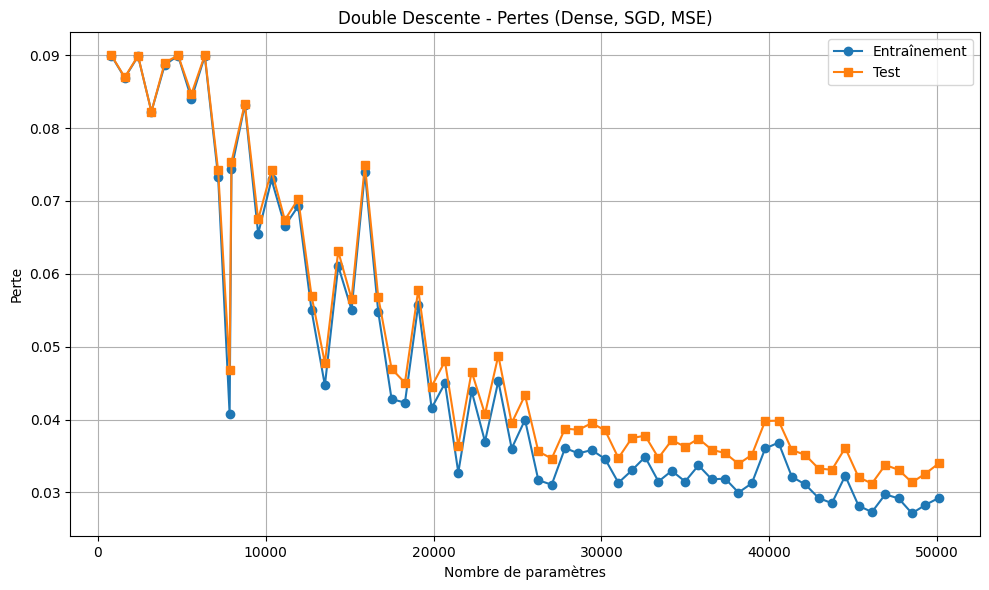

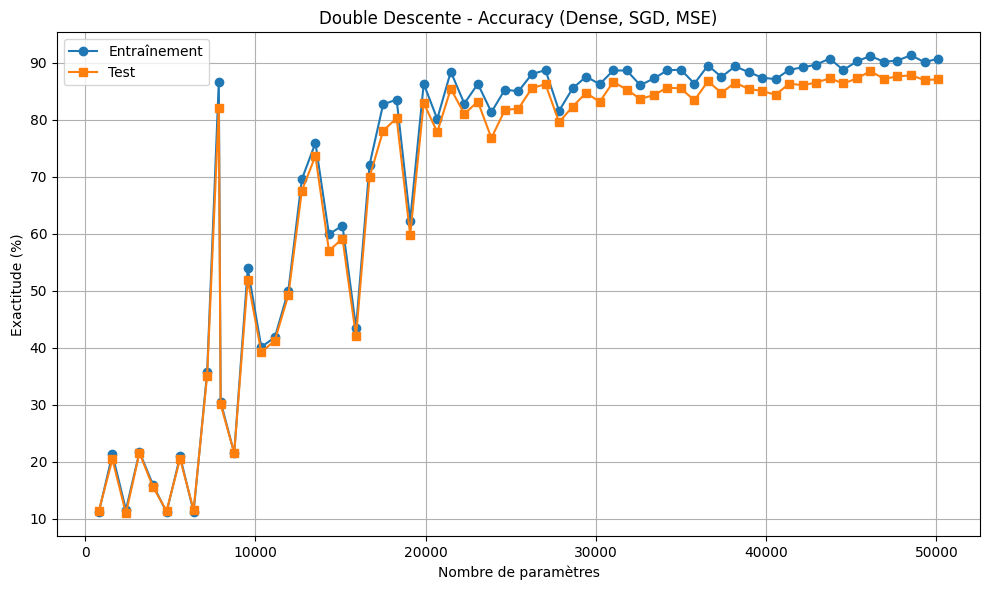

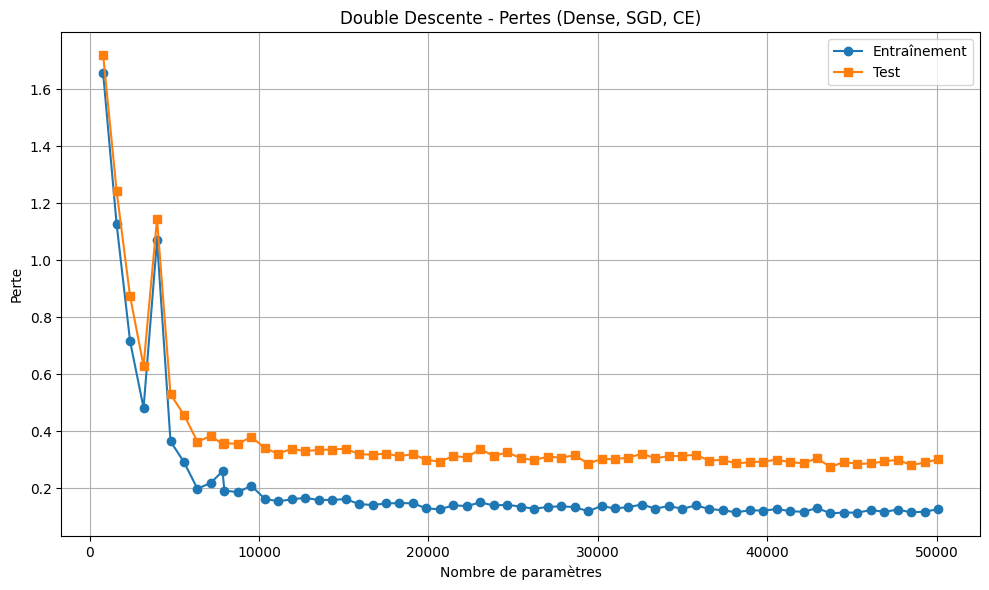

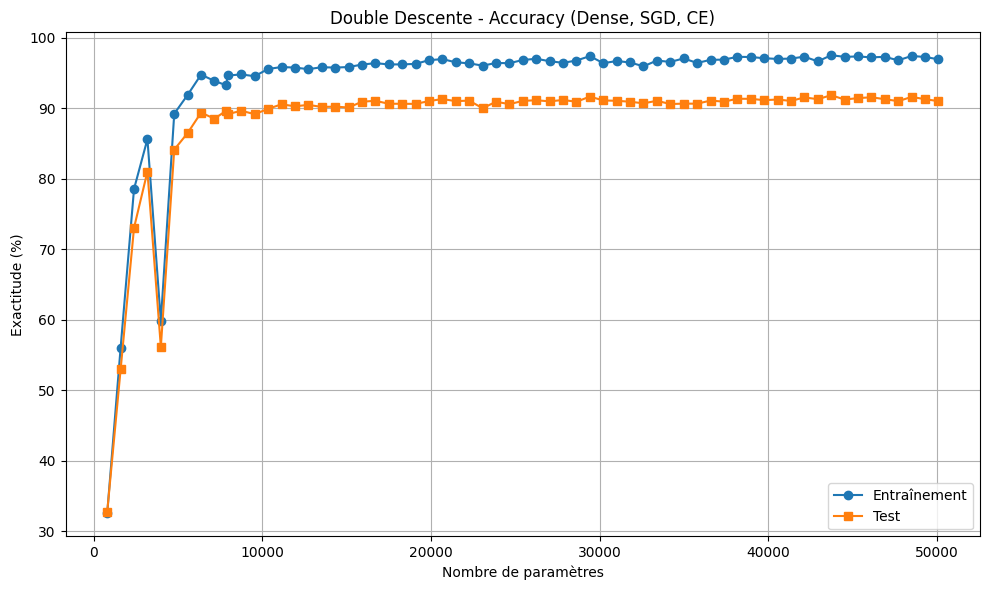

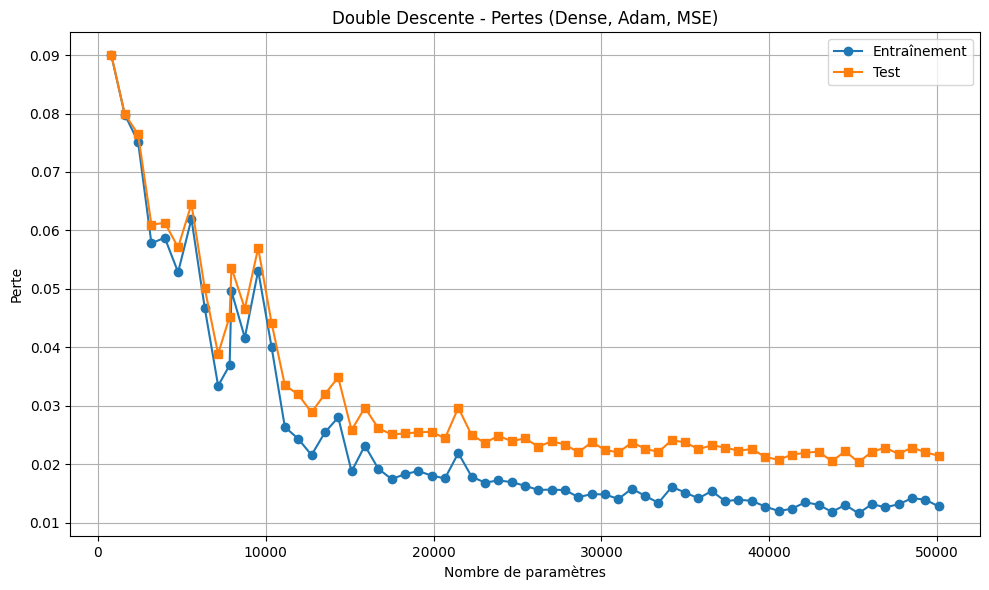

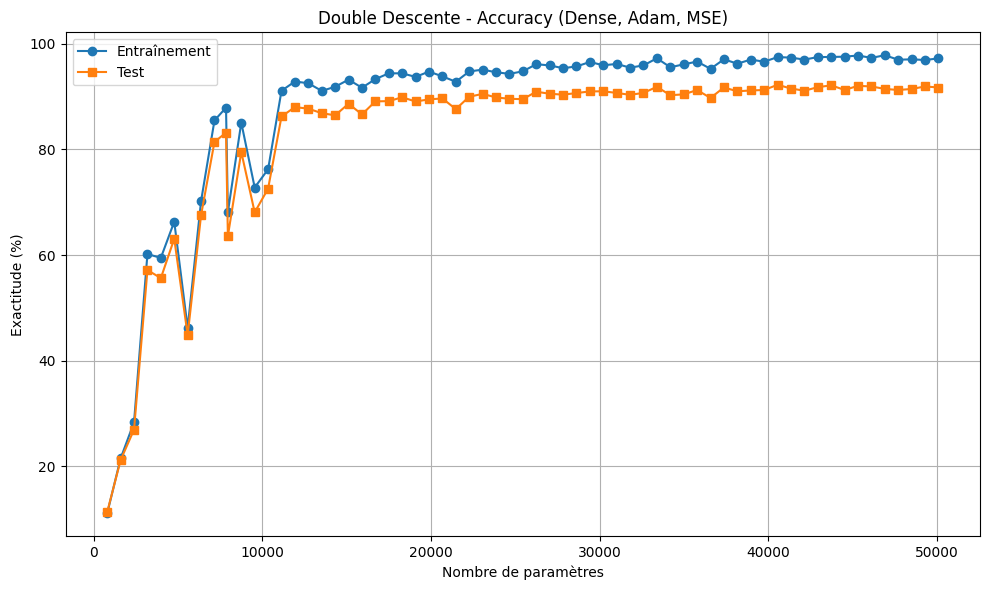

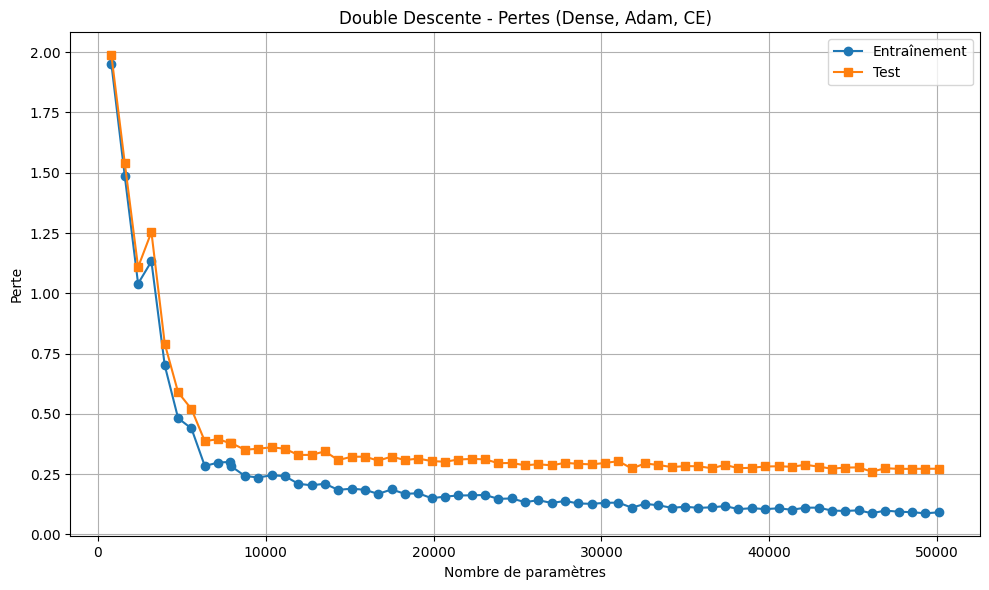

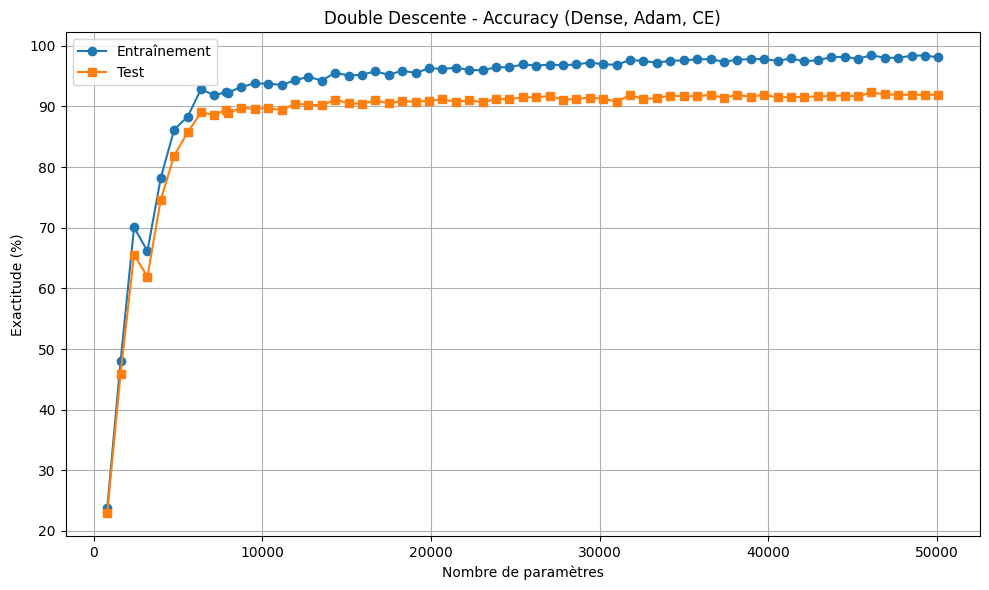

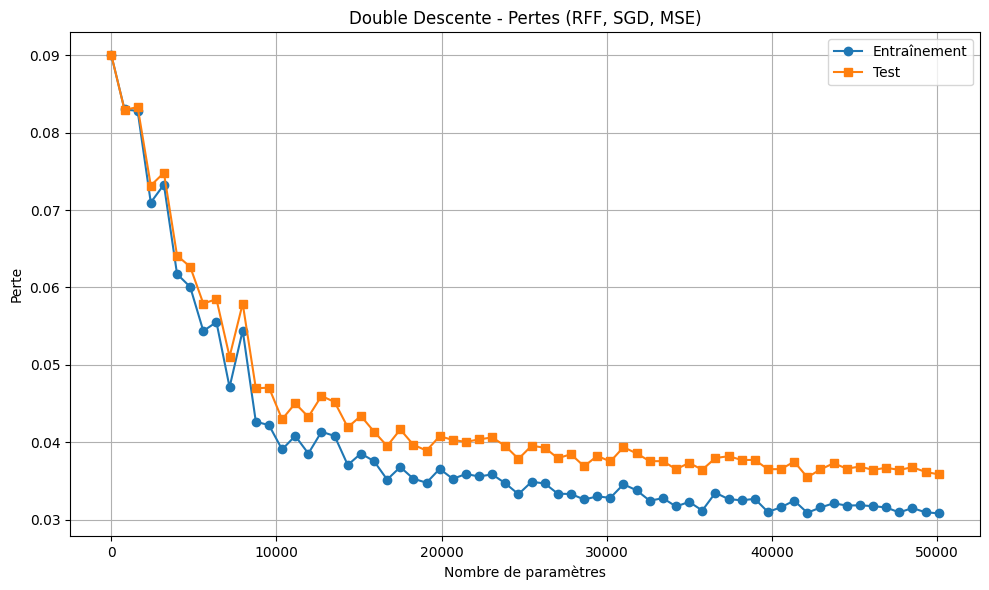

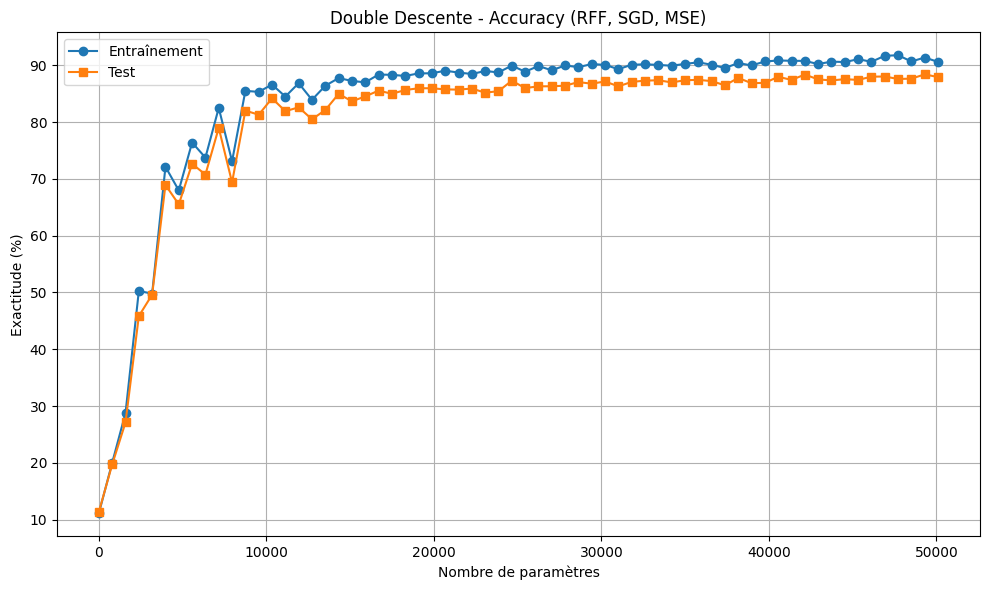

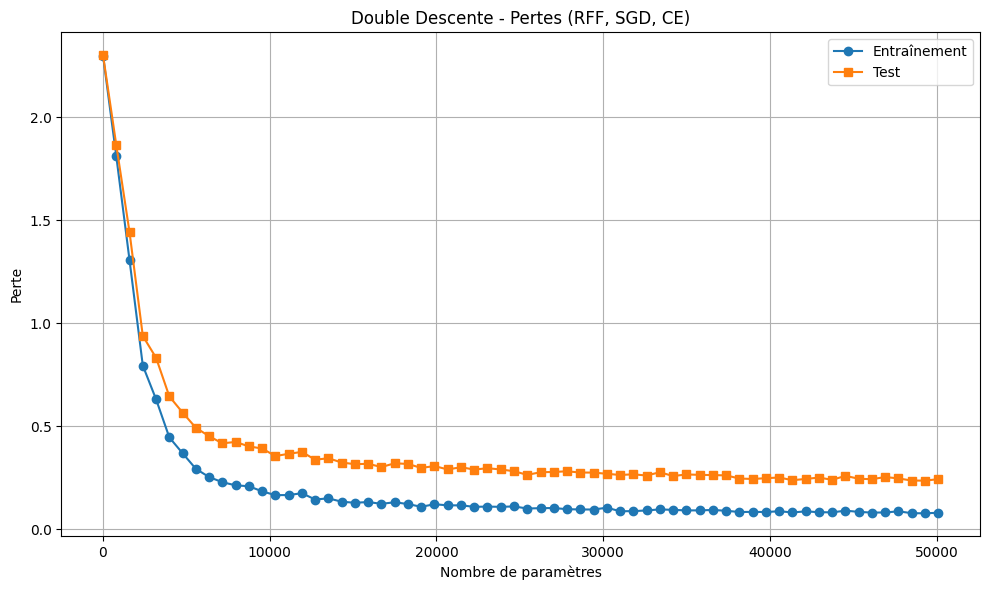

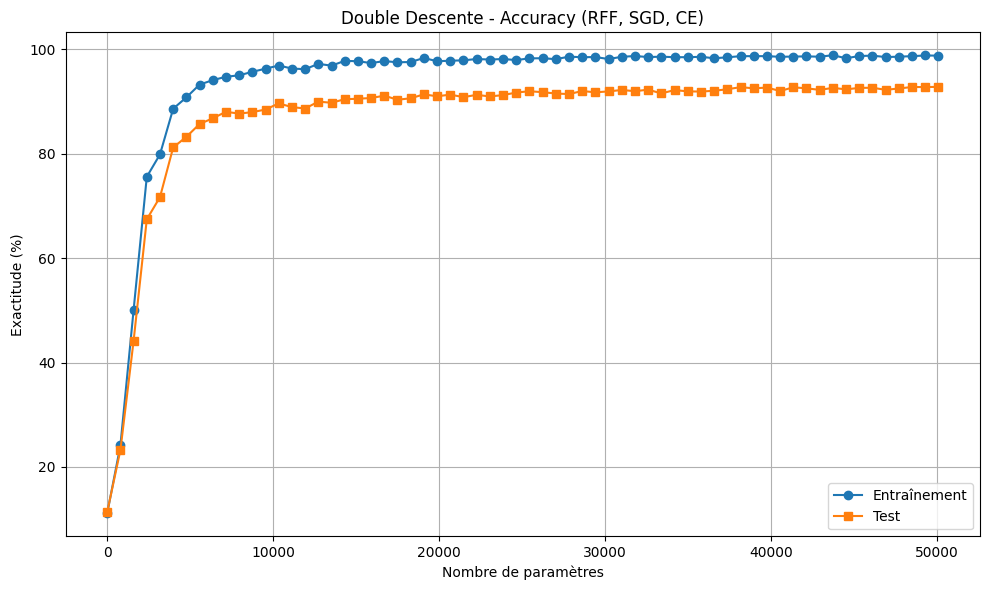

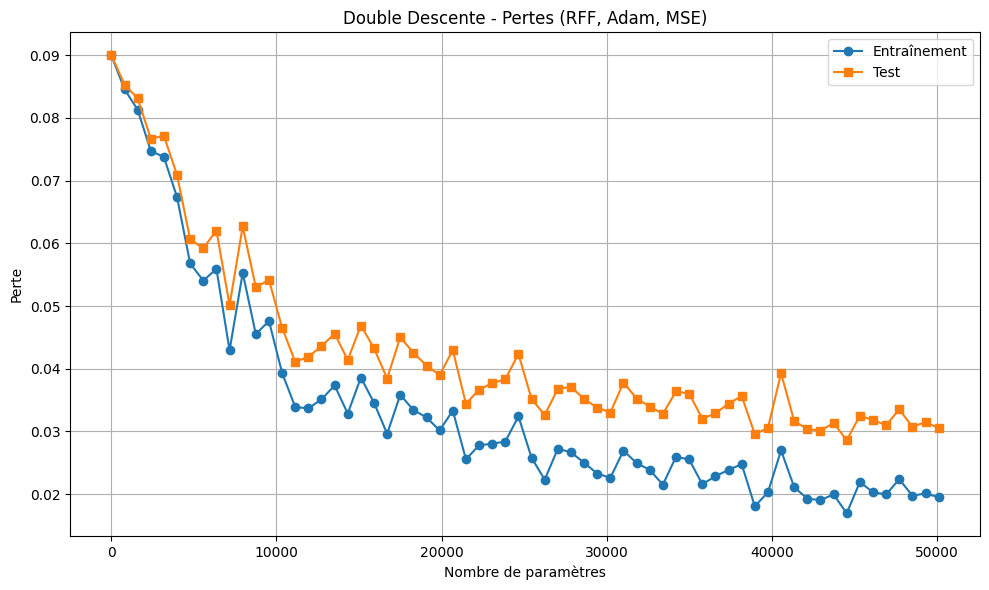

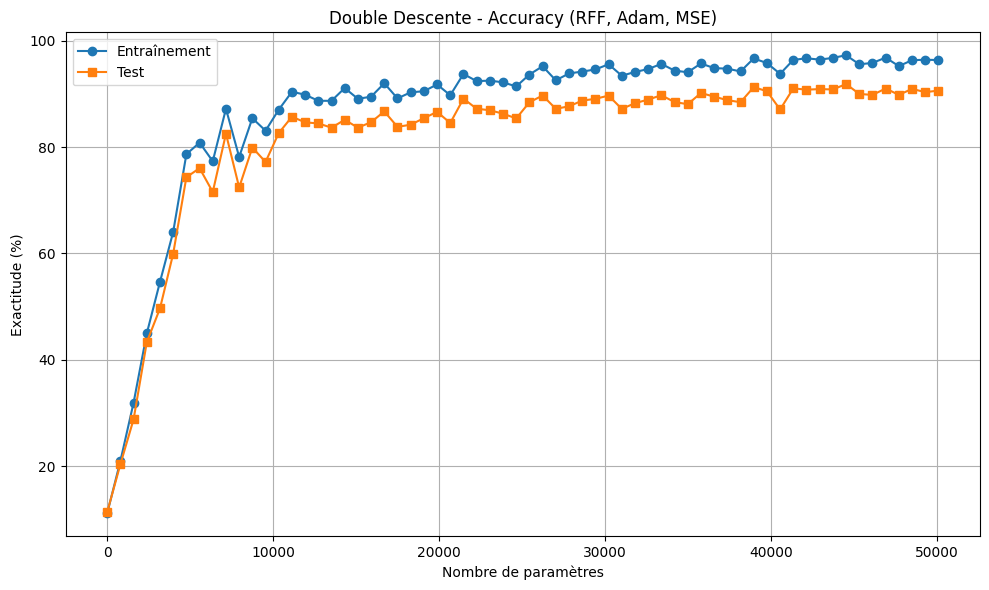

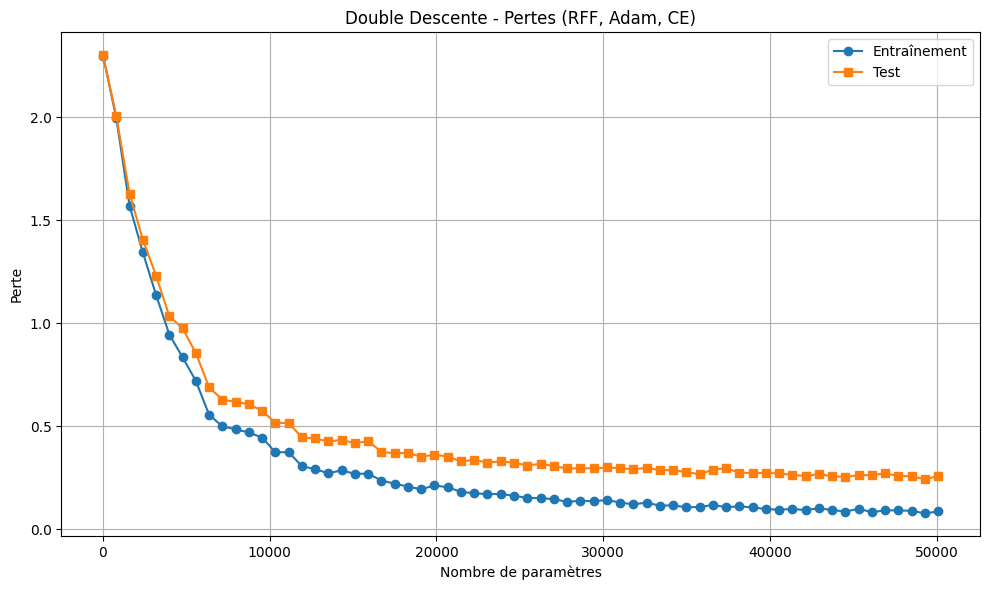

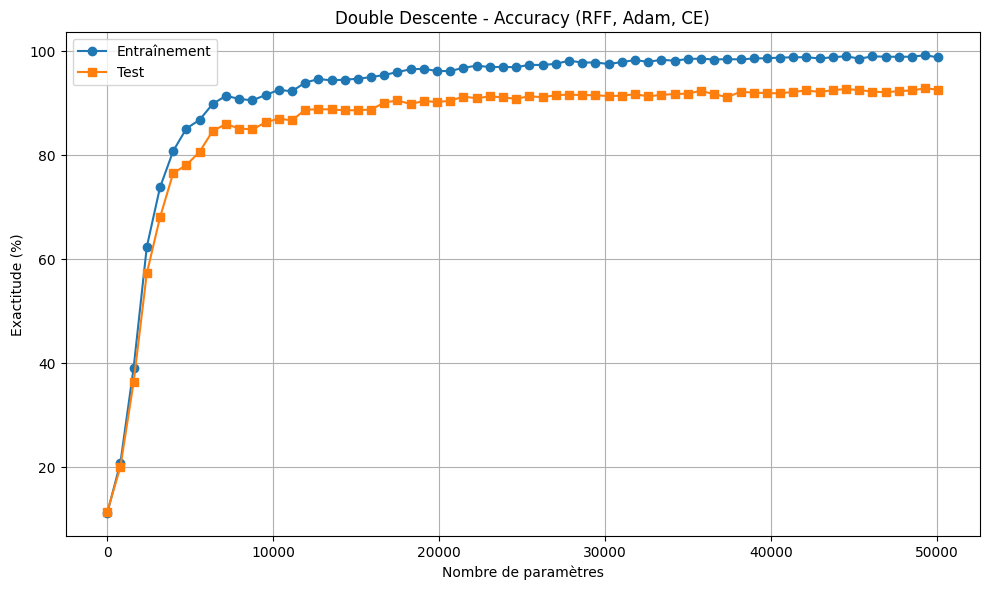

Expérience terminée. Consultez df_results pour les statistiques détaillées.


In [15]:
# -*- coding: utf-8 -*-

# ========================================
# Reproduction du Phénomène de Double Descente sur MNIST
# avec grande flexibilité sur le nombre de paramètres
# ========================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses
from keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time
import pandas as pd


# ------------------------------------------------
# 1. Chargement et Prétraitement des Données MNIST
# ------------------------------------------------

(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# On réduit volontairement le dataset pour exacerber le phénomène de double descente
train_images = train_images[:4000]
train_labels = train_labels[:4000]

# Normalisation
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Flatten (pour réseau dense ou RFF)
train_images_flat = train_images.reshape((-1, 28 * 28))
test_images_flat = test_images.reshape((-1, 28 * 28))


# ----------------------------------------
# 2. Fonctions pour Créer les Modèles
# ----------------------------------------

def create_dense_model(n_hidden_units, activation='relu'):
    """
    Crée un réseau dense à 1 couche cachée de n_hidden_units
    + 1 couche de sortie (10 neurones).
    """
    # Cas particulier : si n_hidden_units == 0,
    # on met directement une seule couche Dense(10) (pas de couche cachée).
    if n_hidden_units == 0:
        model = keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(10, activation='linear')
        ])
    else:
        model = keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(n_hidden_units, activation=activation),
            layers.Dense(10, activation='linear')
        ])
    return model


def create_rff_model(n_components, activation='cos'):
    """
    Exemple simplifié de Random Fourier Features :
    Ici, on simule la projection aléatoire par une Dense "gelée"
    + cos() sur la sortie, puis une Dense(10).
    
    NB : Dans la pratique, on gèlerait la couche RFF (trainable=False)
    pour de "vraies" RFF, mais ici on la laisse entraînable pour comparer
    avec la version Dense "classique".
    """
    # Pour rester simple, on va juste reproduire la même forme
    # de calcul du nombre de paramètres que create_dense_model,
    # avec ou sans activation cos() (optionnel).
    # 
    # Dans un vrai RFF, on ferait :
    #   - W ~ N(0, gamma^2 I)
    #   - b ~ Uniform(0, 2pi)
    #   - projection = cos(Wx + b)
    #   - Dense(10)
    # Mais ici, restons minimalistes.
    
    inputs = layers.Input(shape=(784,))
    # Couche "projet" (équivalent RFF), trainable par simplicité :
    proj = layers.Dense(n_components, use_bias=True)(inputs)
    if activation == 'cos':
        proj = layers.Lambda(lambda x: tf.math.cos(x))(proj)
    # Couche de sortie
    outputs = layers.Dense(10, activation='linear')(proj)
    
    model = keras.Model(inputs, outputs)
    return model


# ---------------------------
# 3. Configuration Générale
# ---------------------------

# Pour varier plus largement, on crée ci-dessous une liste
# de neurones cachés allant de 0 à 63 (pour un total de paramètres
# allant d'environ 7,850 à ~50k).
n_hidden_units_list = list(range(0, 64))  # 0..63

# Idem pour le RFF : n_components = 0..63
n_components_list = list(range(0, 64))

model_types = ['Dense', 'RFF']

optimizers_dict = {
    'SGD': {
        'class': optimizers.SGD,
        'params': {'learning_rate': 0.01, 'momentum': 0.95}
    },
    'Adam': {
        'class': optimizers.Adam,
        'params': {'learning_rate': 0.001}
    }
}

loss_functions_dict = {
    'MSE': losses.MeanSquaredError(),
    'CE': losses.SparseCategoricalCrossentropy(from_logits=True)
}

max_epochs = 20  # On peut ajuster ce nombre d'époques


# ------------------------------------
# 4. Dictionnaire pour Sauvegarder les Résultats
# ------------------------------------

results = {
    'model': [],
    'optimizer': [],
    'loss_function': [],
    'n_hidden_units_or_rff': [],
    'n_parameters': [],
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': [],
    'training_time': []
}


# ------------------------------------
# 5. Boucles d'Entraînement / Évaluation
# ------------------------------------

print("Processing calculations...")

for model_type in model_types:
    for optimizer_name, optimizer_info in optimizers_dict.items():
        optimizer_class = optimizer_info['class']
        optimizer_params = optimizer_info['params']
        for loss_name, loss_fn in loss_functions_dict.items():
            
            if model_type == 'Dense':
                iterable_list = n_hidden_units_list
                desc_name = f"{model_type}-{optimizer_name}-{loss_name}"
                
            else:  # RFF
                iterable_list = n_components_list
                desc_name = f"{model_type}-{optimizer_name}-{loss_name}"
            
            for n_units in tqdm(iterable_list, desc=f"Modèles {desc_name}"):
                
                start_time = time.time()
                
                # Création de l'optimiseur
                optimizer = optimizer_class(**optimizer_params)
                
                # Création du modèle
                if model_type == 'Dense':
                    model = create_dense_model(n_units, activation='relu')
                else:
                    model = create_rff_model(n_units, activation='cos')
                
                # Compilation
                model.compile(optimizer=optimizer,
                              loss=loss_fn,
                              metrics=['accuracy'])
                
                # Option : LearningRateScheduler pour ajuster le LR
                def scheduler(epoch, lr):
                    # Exemple : on diminue le LR toutes les 10 époques
                    if (epoch + 1) % 10 == 0:
                        return lr * 0.9
                    else:
                        return lr
                
                lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
                
                # Entraînement
                history = model.fit(
                    train_images_flat,
                    tf.one_hot(train_labels, 10) if loss_name == 'MSE' else train_labels,
                    epochs=max_epochs,
                    batch_size=128,
                    verbose=0,
                    callbacks=[lr_scheduler]
                )
                
                # Évaluation
                if loss_name == 'MSE':
                    train_loss, train_acc = model.evaluate(
                        train_images_flat, tf.one_hot(train_labels, 10), verbose=0
                    )
                    test_loss, test_acc = model.evaluate(
                        test_images_flat, tf.one_hot(test_labels, 10), verbose=0
                    )
                else:
                    train_loss, train_acc = model.evaluate(
                        train_images_flat, train_labels, verbose=0
                    )
                    test_loss, test_acc = model.evaluate(
                        test_images_flat, test_labels, verbose=0
                    )
                
                # Nombre total de paramètres
                n_params = model.count_params()
                
                # Sauvegarde dans le dictionnaire
                results['model'].append(model_type)
                results['optimizer'].append(optimizer_name)
                results['loss_function'].append(loss_name)
                results['n_hidden_units_or_rff'].append(n_units)
                results['n_parameters'].append(n_params)
                results['train_losses'].append(train_loss)
                results['test_losses'].append(test_loss)
                results['train_accuracies'].append(train_acc * 100)
                results['test_accuracies'].append(test_acc * 100)
                
                elapsed_time = time.time() - start_time
                results['training_time'].append(
                    time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
                )
                '''
                print(f"Terminé : {model_type}-{optimizer_name}-{loss_name} | "
                      f"Units/RFF: {n_units}, Paramètres: {n_params}, "
                      f"TrainAcc: {train_acc*100:.2f}%, TestAcc: {test_acc*100:.2f}%, "
                      f"Temps: {elapsed_time:.2f}s")
                '''

# ------------------------------------
# 6. Création d'un DataFrame de Résultats
# ------------------------------------

df_results = pd.DataFrame(results)


# ------------------------------------
# 7. Fonction de Visualisation
# ------------------------------------

def plot_double_descent(df, model_type, optimizer, loss_function):
    """
    Trace la courbe de perte et la courbe d'accuracy
    en fonction du nombre de paramètres (pour un triplet
    model_type / optimizer / loss_function donné).
    """
    subset = df[(df['model'] == model_type) &
                (df['optimizer'] == optimizer) &
                (df['loss_function'] == loss_function)]
    
    # Tri par nombre de paramètres (important pour un tracé correct)
    subset = subset.sort_values(by='n_parameters')
    
    plt.figure(figsize=(10, 6))
    plt.plot(subset['n_parameters'], subset['train_losses'], marker='o', label='Entraînement')
    plt.plot(subset['n_parameters'], subset['test_losses'], marker='s', label='Test')
    plt.xlabel('Nombre de paramètres')
    plt.ylabel('Perte')
    plt.title(f'Double Descente - Pertes ({model_type}, {optimizer}, {loss_function})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(subset['n_parameters'], subset['train_accuracies'], marker='o', label='Entraînement')
    plt.plot(subset['n_parameters'], subset['test_accuracies'], marker='s', label='Test')
    plt.xlabel('Nombre de paramètres')
    plt.ylabel('Exactitude (%)')
    plt.title(f'Double Descente - Accuracy ({model_type}, {optimizer}, {loss_function})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ------------------------------------
# 8. Visualisation des Résultats
# ------------------------------------
for mtype in model_types:
    for opt_name in optimizers_dict.keys():
        for loss_name in loss_functions_dict.keys():
            plot_double_descent(df_results, mtype, opt_name, loss_name)

print("Expérience terminée. Consultez df_results pour les statistiques détaillées.")

Processing calculations...


Models LR-SGD-MSE:   0%|          | 0/64 [00:00<?, ?it/s]Python(90400) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90401) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90402) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90403) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90404) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90405) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90407) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90408) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Models RFF-Adam-CE: 100%|██████████| 64/64 [08:05<00:00,  7.5

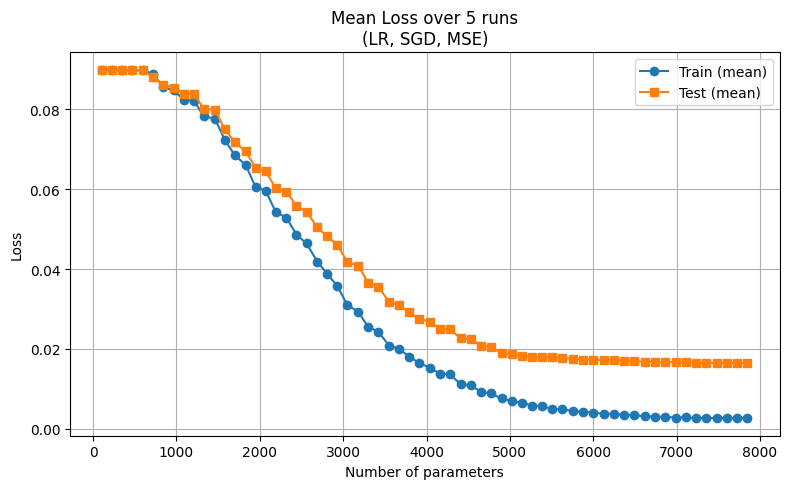

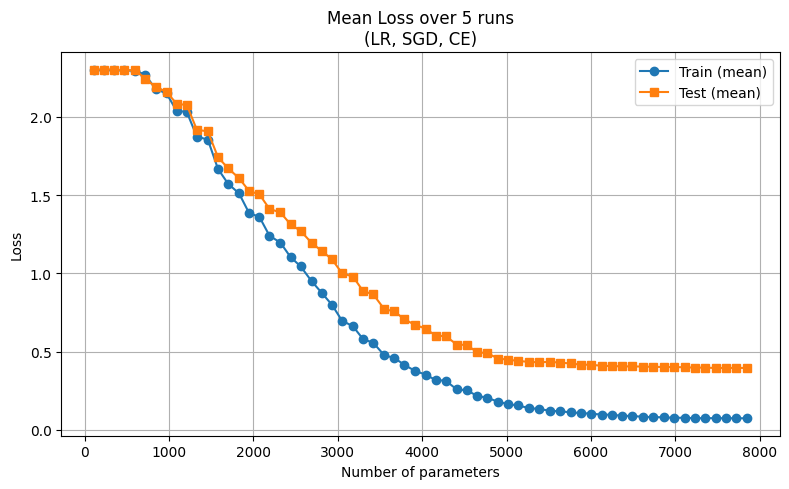

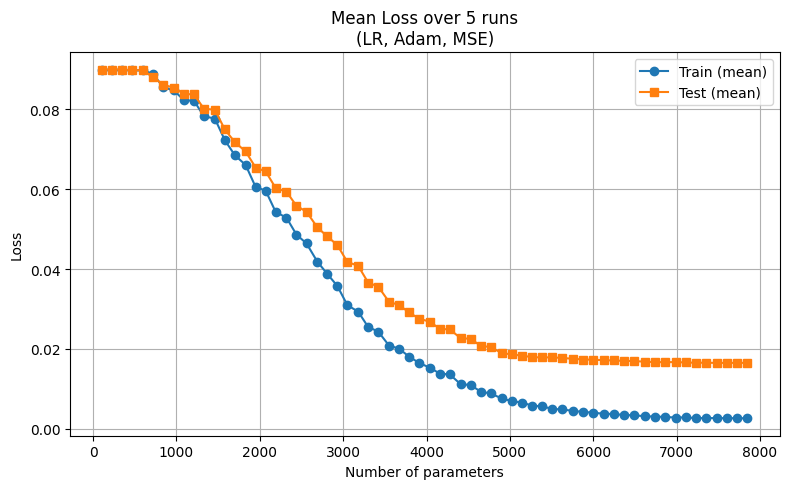

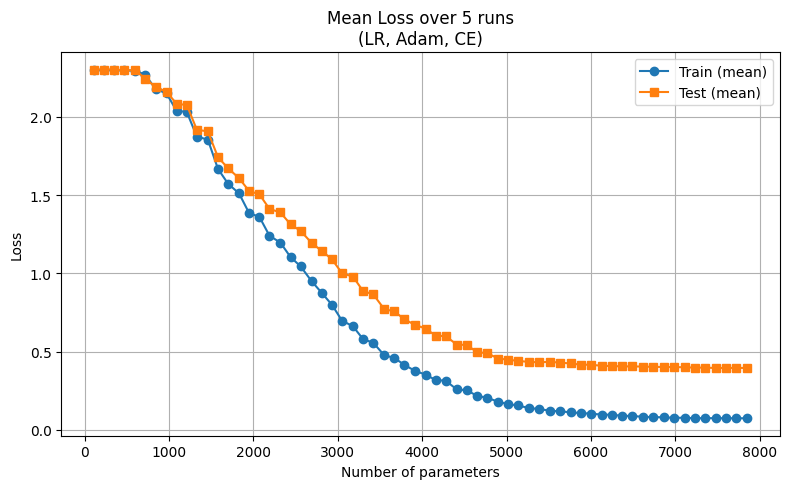

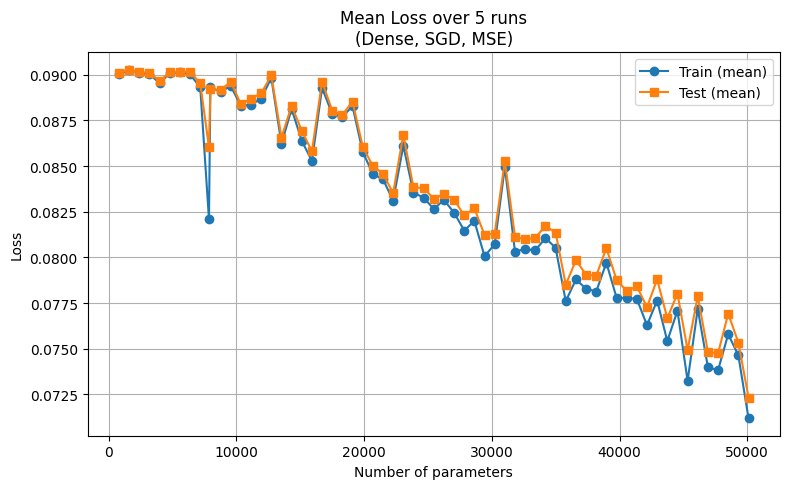

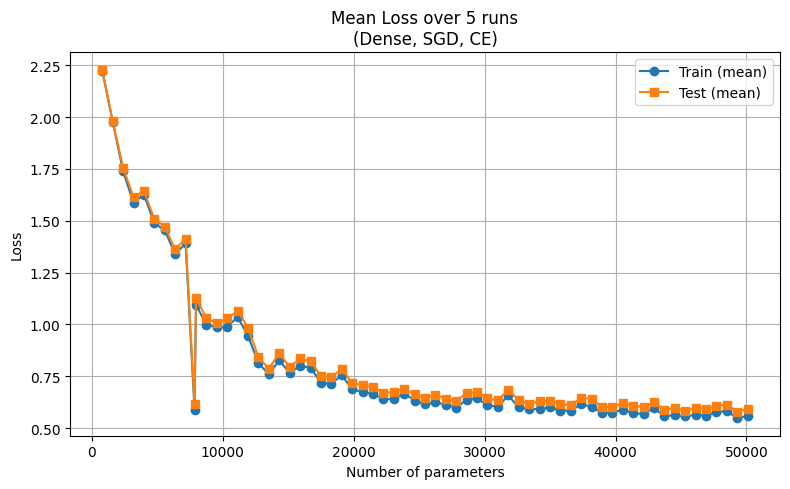

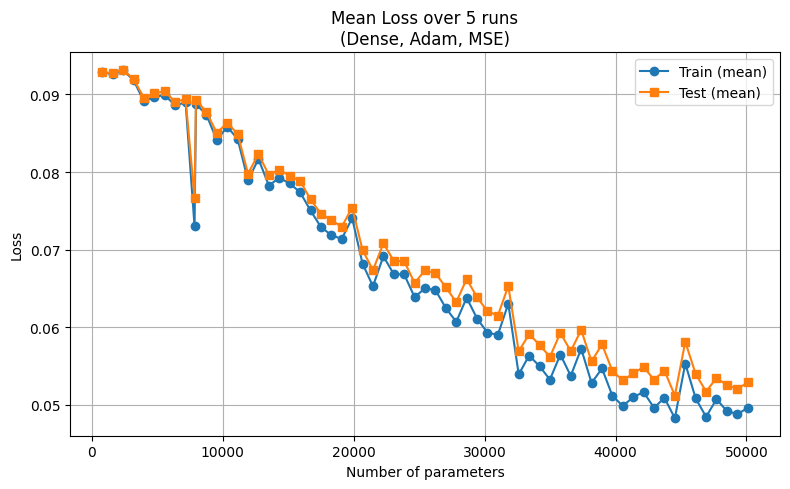

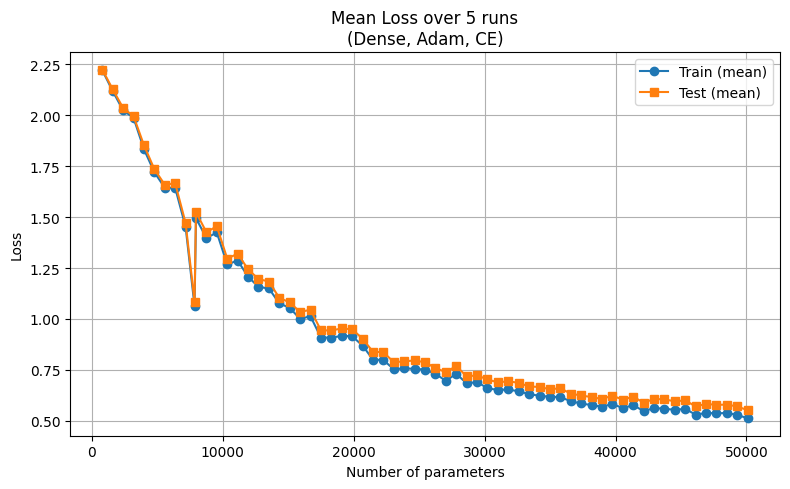

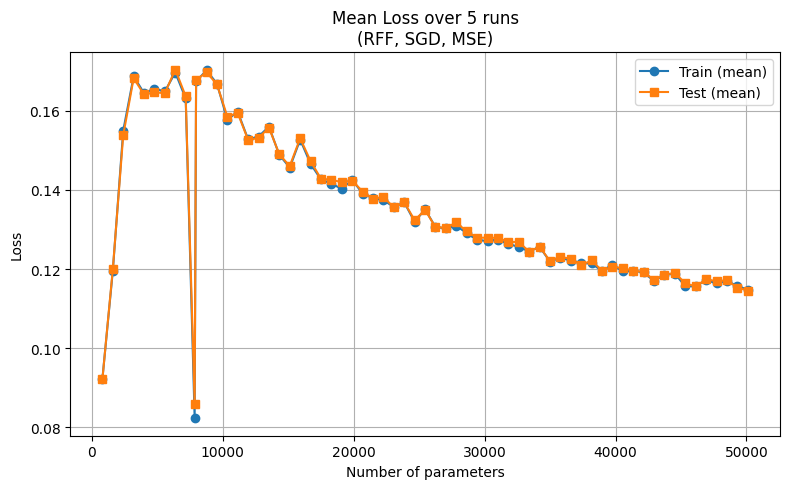

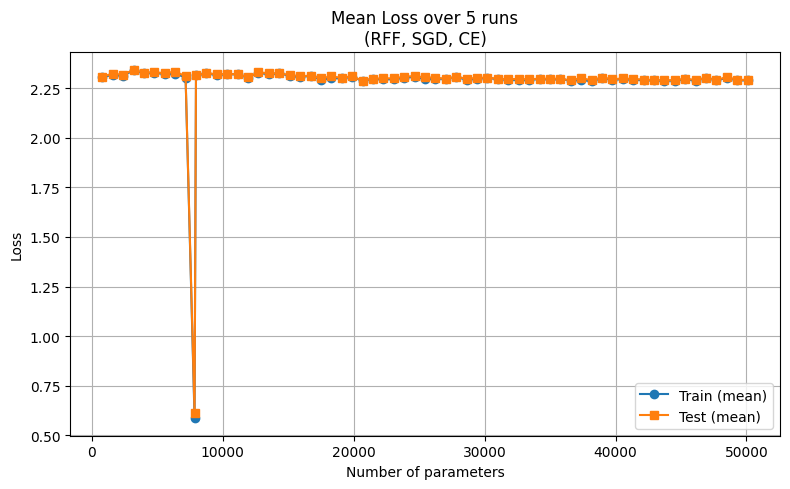

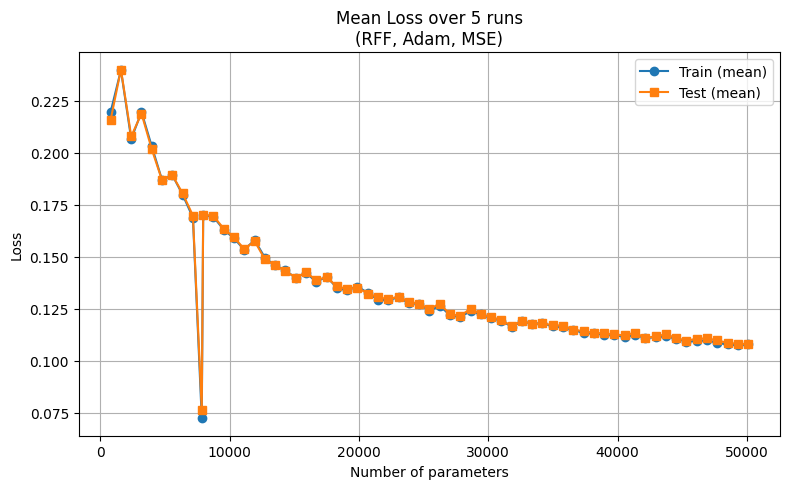

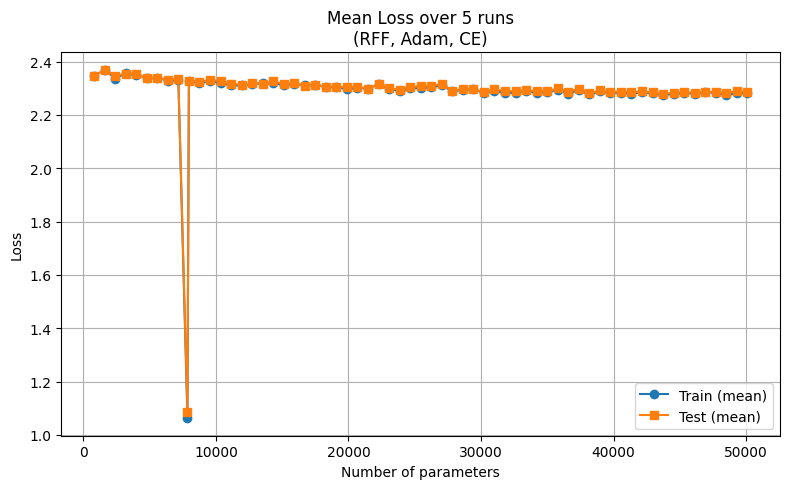

Experiment finished. Check df_agg for averaged statistics.


In [14]:
import warnings
warnings.filterwarnings("ignore")  # Ignore all Python warnings

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Ignore TensorFlow info/warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# Pour la régression linéaire (LR) en scikit‑learn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, mean_squared_error

# ------------------------------------------------
# 1. Load and Preprocess MNIST Data
# ------------------------------------------------

(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Réduire volontairement la taille du dataset pour accélérer encore (optionnel)
train_images = train_images[:4000]
train_labels = train_labels[:4000]

# Normalisation
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Flatten
train_images_flat = train_images.reshape((-1, 28 * 28))
test_images_flat = test_images.reshape((-1, 28 * 28))

# ------------------------------------------------
# 2. Define a Custom Random Fourier Features Layer
# ------------------------------------------------

class RandomFourierFeatures(layers.Layer):
    """
    Custom Keras layer that computes Random Fourier Features (RFF):
      z(x) = sqrt(2/n_components) * cos(xW + b),
    where:
      - W ~ N(0, 2*gamma*I)
      - b ~ Uniform(0, 2pi)
    Weights are non-trainable.
    """
    def __init__(self, n_components=100, gamma=0.05, random_state=42, **kwargs):
        super(RandomFourierFeatures, self).__init__(**kwargs)
        self.n_components = n_components
        self.gamma = gamma
        self.random_state = random_state

    def build(self, input_shape):
        d = input_shape[-1]
        np.random.seed(self.random_state)
        W_init = np.random.normal(loc=0.0, scale=np.sqrt(2 * self.gamma),
                                  size=(d, self.n_components))
        b_init = np.random.uniform(low=0.0, high=2 * np.pi,
                                   size=(self.n_components,))
        
        self.W = self.add_weight(
            name="W",
            shape=W_init.shape,
            initializer=tf.constant_initializer(W_init),
            trainable=False
        )
        self.b = self.add_weight(
            name="b",
            shape=b_init.shape,
            initializer=tf.constant_initializer(b_init),
            trainable=False
        )
        super(RandomFourierFeatures, self).build(input_shape)

    def call(self, inputs):
        projection = tf.matmul(inputs, self.W) + self.b
        Z = tf.math.cos(projection) * tf.sqrt(2.0 / tf.cast(self.n_components, tf.float32))
        return Z

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_components)

# ------------------------------------------------
# 3. Model Building Functions
# ------------------------------------------------

def create_dense_model(n_hidden_units, activation='relu'):
    if n_hidden_units == 0:
        # Régression linéaire Keras sur 784 features
        model = keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(10, activation='linear')
        ])
        return model
    
    model = keras.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(n_hidden_units, activation=activation),
        layers.Dense(10, activation='linear')
    ])
    return model

def create_rff_model(n_components, gamma=0.05, random_state=42):
    if n_components == 0:
        # Régression linéaire Keras sur 784 features
        model = keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(10, activation='linear')
        ])
        return model
    
    inputs = layers.Input(shape=(784,))
    rff_features = RandomFourierFeatures(n_components=n_components,
                                         gamma=gamma,
                                         random_state=random_state)(inputs)
    outputs = layers.Dense(10, activation='linear')(rff_features)
    model = keras.Model(inputs, outputs)
    return model


# ------------------------------------------------
# 4. General Configuration
# ------------------------------------------------

# LR: nombre de features de 10 à 784
lr_features_list = [int(x) for x in np.linspace(10, 784, 64)]
# Dense/RFF: variation de 0 à 63
n_values_list = [int(x) for x in np.linspace(0, 63, 64)]

model_types = ['LR', 'Dense', 'RFF']

optimizers_dict = {
    'SGD': {
        'class': optimizers.SGD,
        'params': {'learning_rate': 0.01, 'momentum': 0.95}
    },
    'Adam': {
        'class': optimizers.Adam,
        'params': {'learning_rate': 0.001}
    }
}

loss_functions_dict = {
    'MSE': losses.MeanSquaredError(),
    'CE': losses.SparseCategoricalCrossentropy(from_logits=True)
}

# Paramètres modifiés pour accélérer
max_epochs = 3       # Moins d'époques
NUM_RUNS = 5         # Moins de répétitions
BATCH_SIZE = 256     # Batch plus grand

# ------------------------------------------------
# 5. Collect All Results (Multiple Runs)
# ------------------------------------------------

all_results = []

print("Processing calculations...")

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, mean_squared_error

for model_type in model_types:
    for optimizer_name, optimizer_info in optimizers_dict.items():
        optimizer_class = optimizer_info['class']
        optimizer_params = optimizer_info['params']
        for loss_name, loss_fn in loss_functions_dict.items():
            
            if model_type == 'LR':
                iterate_values = lr_features_list
            else:
                iterate_values = n_values_list
            
            # Boucle sur la complexité
            for n_val in tqdm(iterate_values, desc=f"Models {model_type}-{optimizer_name}-{loss_name}"):
                # Répéter l'entraînement NUM_RUNS fois
                for run_idx in range(NUM_RUNS):
                    
                    if model_type == 'LR':
                        # LogisticRegression (scikit-learn) -> n_jobs=-1 pour paralléliser
                        X_train = train_images_flat[:, :n_val]
                        X_test = test_images_flat[:, :n_val]
                        clf = LogisticRegression(
                            multi_class='multinomial',
                            solver='lbfgs',
                            max_iter=500,      # un peu moins pour accélérer
                            random_state=run_idx,
                            n_jobs=-1          # utiliser tous les cœurs CPU
                        )
                        clf.fit(X_train, train_labels)

                        probs_train = clf.predict_proba(X_train)
                        probs_test = clf.predict_proba(X_test)

                        if loss_name == 'CE':
                            train_loss = log_loss(train_labels, probs_train)
                            test_loss = log_loss(test_labels, probs_test)
                        else:
                            # MSE -> one-hot
                            n_classes = probs_train.shape[1]
                            onehot_train = np.eye(n_classes)[train_labels]
                            onehot_test = np.eye(n_classes)[test_labels]
                            train_loss = mean_squared_error(onehot_train, probs_train)
                            test_loss = mean_squared_error(onehot_test, probs_test)

                        n_params = n_val * 10 + 10
                    
                    else:
                        # Keras
                        model = None
                        if model_type == 'Dense':
                            model = create_dense_model(n_val, activation='relu')
                        else:
                            model = create_rff_model(n_val, gamma=0.05, random_state=42)
                        
                        optimizer = optimizer_class(**optimizer_params)
                        model.compile(optimizer=optimizer, loss=loss_fn)
                        
                        # On retire la LearningRateScheduler pour gagner du temps
                        
                        model.fit(
                            train_images_flat,
                            tf.one_hot(train_labels, 10) if loss_name == 'MSE' else train_labels,
                            epochs=max_epochs,
                            batch_size=BATCH_SIZE,
                            verbose=0
                        )
                        
                        if loss_name == 'MSE':
                            train_loss = model.evaluate(
                                train_images_flat,
                                tf.one_hot(train_labels, 10),
                                verbose=0
                            )
                            test_loss = model.evaluate(
                                test_images_flat,
                                tf.one_hot(test_labels, 10),
                                verbose=0
                            )
                        else:
                            train_loss = model.evaluate(train_images_flat, train_labels, verbose=0)
                            test_loss = model.evaluate(test_images_flat, test_labels, verbose=0)
                        
                        n_params = model.count_params()
                    
                    # Enregistrer les résultats
                    all_results.append({
                        'model': model_type,
                        'optimizer': optimizer_name,
                        'loss_function': loss_name,
                        'n_features_or_units': n_val,
                        'n_parameters': n_params,
                        'train_loss': train_loss,
                        'test_loss': test_loss
                    })

# ------------------------------------------------
# 6. DataFrame and Aggregation
# ------------------------------------------------

df_all = pd.DataFrame(all_results)

df_agg = df_all.groupby(
    ['model', 'optimizer', 'loss_function', 'n_features_or_units', 'n_parameters'],
    as_index=False
).agg({
    'train_loss': 'mean',
    'test_loss': 'mean'
}).rename(columns={
    'train_loss': 'train_loss_mean',
    'test_loss': 'test_loss_mean'
})

# ------------------------------------------------
# 7. Visualization: Plot Only the Loss
# ------------------------------------------------

import matplotlib.pyplot as plt

def plot_mean_loss(df, model_type, optimizer, loss_function):
    subset = df[
        (df['model'] == model_type) &
        (df['optimizer'] == optimizer) &
        (df['loss_function'] == loss_function)
    ].copy()
    
    subset.sort_values(by='n_parameters', inplace=True)
    
    plt.figure(figsize=(8, 5))
    plt.plot(subset['n_parameters'], subset['train_loss_mean'],
             marker='o', label='Train (mean)')
    plt.plot(subset['n_parameters'], subset['test_loss_mean'],
             marker='s', label='Test (mean)')
    plt.xlabel('Number of parameters')
    plt.ylabel('Loss')
    plt.title(f'Mean Loss over {NUM_RUNS} runs\n({model_type}, {optimizer}, {loss_function})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# 8. Plot the Results
# ------------------------------------------------

for mtype in model_types:
    for opt_name in optimizers_dict.keys():
        for loss_name in loss_functions_dict.keys():
            plot_mean_loss(df_agg, mtype, opt_name, loss_name)

print("Experiment finished. Check df_agg for averaged statistics.")

In [16]:
import warnings
warnings.filterwarnings("ignore")  # Ignore Python warnings

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Ignore TensorFlow info/warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# Pour la régression linéaire (LR) en scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, mean_squared_error

# ------------------------------------------------
# 1. Load and Preprocess MNIST Data
# ------------------------------------------------

(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# On réduit la taille du dataset pour l'exemple
train_images = train_images[:4000]
train_labels = train_labels[:4000]

# Normalisation
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Flatten
train_images_flat = train_images.reshape((-1, 28 * 28))
test_images_flat = test_images.reshape((-1, 28 * 28))

# ------------------------------------------------
# 2. Define a Custom Random Fourier Features Layer
# ------------------------------------------------

class RandomFourierFeatures(layers.Layer):
    """
    Custom Keras layer that computes Random Fourier Features (RFF):
      z(x) = sqrt(2/n_components) * cos(xW + b),
    where:
      - W ~ N(0, 2*gamma*I)
      - b ~ Uniform(0, 2pi)
    Weights are non-trainable.
    """
    def __init__(self, n_components=100, gamma=0.05, random_state=42, **kwargs):
        super(RandomFourierFeatures, self).__init__(**kwargs)
        self.n_components = n_components
        self.gamma = gamma
        self.random_state = random_state

    def build(self, input_shape):
        d = input_shape[-1]
        np.random.seed(self.random_state)
        W_init = np.random.normal(
            loc=0.0,
            scale=np.sqrt(2 * self.gamma),
            size=(d, self.n_components)
        )
        b_init = np.random.uniform(
            low=0.0,
            high=2 * np.pi,
            size=(self.n_components,)
        )
        
        self.W = self.add_weight(
            name="W",
            shape=W_init.shape,
            initializer=tf.constant_initializer(W_init),
            trainable=False
        )
        self.b = self.add_weight(
            name="b",
            shape=b_init.shape,
            initializer=tf.constant_initializer(b_init),
            trainable=False
        )
        super(RandomFourierFeatures, self).build(input_shape)

    def call(self, inputs):
        projection = tf.matmul(inputs, self.W) + self.b
        Z = tf.math.cos(projection) * tf.sqrt(2.0 / tf.cast(self.n_components, tf.float32))
        return Z

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_components)

# ------------------------------------------------
# 3. Model Building Functions
# ------------------------------------------------

def create_dense_model(n_hidden_units, activation='relu'):
    """Dense NN : 1 couche cachée + 1 couche de sortie."""
    if n_hidden_units == 0:
        # Modèle linéaire Keras
        model = keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(10, activation='linear')
        ])
        return model
    
    model = keras.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(n_hidden_units, activation=activation),
        layers.Dense(10, activation='linear')
    ])
    return model

def create_rff_model(n_components, gamma=0.05, random_state=42):
    """Modèle RFF : couche RFF custom + Dense(10)."""
    if n_components == 0:
        # Modèle linéaire Keras
        model = keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(10, activation='linear')
        ])
        return model
    
    inputs = layers.Input(shape=(784,))
    rff_features = RandomFourierFeatures(
        n_components=n_components,
        gamma=gamma,
        random_state=random_state
    )(inputs)
    outputs = layers.Dense(10, activation='linear')(rff_features)
    model = keras.Model(inputs, outputs)
    return model

# ------------------------------------------------
# 4. General Configuration
# ------------------------------------------------

lr_features_list = [int(x) for x in np.linspace(10, 10000, 100)]  # moins de points pour l'exemple
n_values_list    = [int(x) for x in np.linspace(0, 63, 10)]    # idem

model_types = ['LR']

optimizers_dict = {
    'SGD': {
        'class': optimizers.SGD,
        'params': {'learning_rate': 0.01, 'momentum': 0.95}
    },
    'Adam': {
        'class': optimizers.Adam,
        'params': {'learning_rate': 0.001}
    }
}

loss_functions_dict = {
    'MSE': losses.MeanSquaredError(),
    'CE': losses.SparseCategoricalCrossentropy(from_logits=True)
}

max_epochs = 3
NUM_RUNS = 2
BATCH_SIZE = 128

# ------------------------------------------------
# 5. Stockage séparé des résultats
# ------------------------------------------------
#  - all_results_LR : résultats pour LR
#  - all_results_Dense : résultats pour Dense
#  - all_results_RFF : résultats pour RFF

all_results_LR = []
all_results_Dense = []
all_results_RFF = []

print("Processing calculations...")

for model_type in model_types:
    for optimizer_name, optimizer_info in optimizers_dict.items():
        optimizer_class = optimizer_info['class']
        optimizer_params = optimizer_info['params']
        for loss_name, loss_fn in loss_functions_dict.items():
            
            # Liste des valeurs à parcourir
            if model_type == 'LR':
                iterate_values = lr_features_list
            else:
                iterate_values = n_values_list
            
            # Boucle sur la complexité (n_val)
            for n_val in tqdm(iterate_values, desc=f"Models {model_type}-{optimizer_name}-{loss_name}"):
                # Exécutions multiples
                for run_idx in range(NUM_RUNS):
                    
                    if model_type == 'LR':
                        # Modèle LR scikit-learn
                        X_train = train_images_flat[:, :n_val]
                        X_test = test_images_flat[:, :n_val]
                        
                        clf = LogisticRegression(
                            multi_class='multinomial',
                            solver='lbfgs',
                            max_iter=500,
                            random_state=run_idx,
                            n_jobs=-1
                        )
                        clf.fit(X_train, train_labels)
                        
                        probs_train = clf.predict_proba(X_train)
                        probs_test = clf.predict_proba(X_test)
                        
                        if loss_name == 'CE':
                            train_loss = log_loss(train_labels, probs_train)
                            test_loss = log_loss(test_labels, probs_test)
                        else:
                            n_classes = probs_train.shape[1]
                            onehot_train = np.eye(n_classes)[train_labels]
                            onehot_test = np.eye(n_classes)[test_labels]
                            train_loss = mean_squared_error(onehot_train, probs_train)
                            test_loss = mean_squared_error(onehot_test, probs_test)
                        
                        n_params = n_val * 10 + 10
                        
                        # On stocke dans all_results_LR
                        all_results_LR.append({
                            'model': 'LR',
                            'optimizer': optimizer_name,
                            'loss_function': loss_name,
                            'n_features_or_units': n_val,
                            'n_parameters': n_params,
                            'train_loss': train_loss,
                            'test_loss': test_loss
                        })
                    
                    elif model_type == 'Dense':
                        # Dense Keras
                        model = create_dense_model(n_val, activation='relu')
                        optimizer = optimizer_class(**optimizer_params)
                        model.compile(optimizer=optimizer, loss=loss_fn)

                        model.fit(
                            train_images_flat,
                            tf.one_hot(train_labels, 10) if loss_name == 'MSE' else train_labels,
                            epochs=max_epochs,
                            batch_size=BATCH_SIZE,
                            verbose=0
                        )
                        
                        if loss_name == 'MSE':
                            train_loss = model.evaluate(
                                train_images_flat,
                                tf.one_hot(train_labels, 10),
                                verbose=0
                            )
                            test_loss = model.evaluate(
                                test_images_flat,
                                tf.one_hot(test_labels, 10),
                                verbose=0
                            )
                        else:
                            train_loss = model.evaluate(train_images_flat, train_labels, verbose=0)
                            test_loss = model.evaluate(test_images_flat, test_labels, verbose=0)
                        
                        n_params = model.count_params()
                        
                        # Stockage dans all_results_Dense
                        all_results_Dense.append({
                            'model': 'Dense',
                            'optimizer': optimizer_name,
                            'loss_function': loss_name,
                            'n_features_or_units': n_val,
                            'n_parameters': n_params,
                            'train_loss': train_loss,
                            'test_loss': test_loss
                        })
                    
                    else:
                        # RFF Keras
                        model = create_rff_model(n_val, gamma=0.05, random_state=42)
                        optimizer = optimizer_class(**optimizer_params)
                        model.compile(optimizer=optimizer, loss=loss_fn)

                        model.fit(
                            train_images_flat,
                            tf.one_hot(train_labels, 10) if loss_name == 'MSE' else train_labels,
                            epochs=max_epochs,
                            batch_size=BATCH_SIZE,
                            verbose=0
                        )
                        
                        if loss_name == 'MSE':
                            train_loss = model.evaluate(
                                train_images_flat,
                                tf.one_hot(train_labels, 10),
                                verbose=0
                            )
                            test_loss = model.evaluate(
                                test_images_flat,
                                tf.one_hot(test_labels, 10),
                                verbose=0
                            )
                        else:
                            train_loss = model.evaluate(train_images_flat, train_labels, verbose=0)
                            test_loss = model.evaluate(test_images_flat, test_labels, verbose=0)
                        
                        n_params = model.count_params()
                        
                        # Stockage dans all_results_RFF
                        all_results_RFF.append({
                            'model': 'RFF',
                            'optimizer': optimizer_name,
                            'loss_function': loss_name,
                            'n_features_or_units': n_val,
                            'n_parameters': n_params,
                            'train_loss': train_loss,
                            'test_loss': test_loss
                        })

print("All computations done.")


# ------------------------------------------------
# 6. Création des DataFrames séparés
# ------------------------------------------------

df_LR = pd.DataFrame(all_results_LR)
df_Dense = pd.DataFrame(all_results_Dense)
df_RFF = pd.DataFrame(all_results_RFF)

# Si on veut concaténer le tout dans un seul df :
# df_all = pd.concat([df_LR, df_Dense, df_RFF], ignore_index=True)


# ------------------------------------------------
# 7. Agrégation : Exemple de moyenne sur les runs
# ------------------------------------------------

def aggregate_results(df):
    """
    Agrège les résultats en prenant la moyenne (train_loss, test_loss)
    groupé par (optimizer, loss_function, n_features_or_units, n_parameters).
    """
    df_agg = df.groupby(
        ['optimizer', 'loss_function', 'n_features_or_units', 'n_parameters'],
        as_index=False
    ).agg({
        'train_loss': 'mean',
        'test_loss': 'mean'
    }).rename(columns={
        'train_loss': 'train_loss_mean',
        'test_loss': 'test_loss_mean'
    })
    return df_agg

df_LR_agg = aggregate_results(df_LR)
df_Dense_agg = aggregate_results(df_Dense)
df_RFF_agg = aggregate_results(df_RFF)

# ------------------------------------------------
# 8. Visualisation séparée (exemple)
# ------------------------------------------------

def plot_mean_loss(df_agg, model_label=""):
    """
    Trace la loss (moyenne) d'entraînement et de test en fonction du n_parameters.
    Suppose que le DataFrame contient n_parameters, train_loss_mean et test_loss_mean.
    """
    df_agg = df_agg.sort_values(by='n_parameters').copy()

    plt.figure(figsize=(7, 5))
    plt.plot(df_agg['n_parameters'], df_agg['train_loss_mean'],
             marker='o', label='Train (mean)')
    plt.plot(df_agg['n_parameters'], df_agg['test_loss_mean'],
             marker='s', label='Test (mean)')
    
    plt.xlabel('Number of parameters')
    plt.ylabel('Loss')
    plt.title(f"Loss vs. #Params - {model_label}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Exemple : tracer LR, Dense, RFF
plot_mean_loss(df_LR_agg,   model_label="LR")
plot_mean_loss(df_Dense_agg,model_label="Dense")
plot_mean_loss(df_RFF_agg,  model_label="RFF")

print("Done. You can now analyze df_LR, df_Dense, df_RFF, or their aggregated versions.")

Processing calculations...


Models LR-Adam-CE: 100%|██████████| 100/100 [06:01<00:00,  3.61s/it]


All computations done.


KeyError: 'optimizer'